In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from scipy import stats 

In [27]:
### CLEANING DATA

###EPITOME
epitome = pd.read_csv("original_samples/sample_epitome.csv")
epitome = epitome[
    [
        "sp_id",
        "rp_id",
        "level_emotional_reactions",
        "level_explorations",
        "level_interpretations",
    ]
]
epitome.to_csv("data/epitome/sample_ratings_crowdsourced.csv", index=False)

###PERCEIVED EMPATHY
perceived_empathy = pd.read_csv(
    "original_samples/sample_perceived_empathy_annotations.csv"
)
perceived_empathy = perceived_empathy.rename(columns={"OriginalDiscloserID": "id"})
perceived_empathy = perceived_empathy[
    [
        "id",
        "m_understood",
        "m_validated",
        "m_affirmed",
        "m_seen",
        "m_accepted",
        "m_caredfor",
        "m_emotional",
        "m_practical",
        "m_motivation",
    ]
]
perceived_empathy.to_csv(
    "data/perceived_empathy/sample_ratings_crowdsourced.csv", index=False
)

###EMPATHETIC DIALOGUES
empathetic_dialogues = pd.read_csv("original_samples/sample_empatheticdialogues.csv")
empathetic_dialogues = empathetic_dialogues.drop_duplicates(subset=["conv_id"])
empathetic_dialogues["empathy"] = empathetic_dialogues[["empathy1", "empathy2"]].mean(
    axis=1
)
empathetic_dialogues["fluency"] = empathetic_dialogues[["fluency1", "fluency2"]].mean(
    axis=1
)
empathetic_dialogues["relevance"] = empathetic_dialogues[
    ["relevance1", "relevance2"]
].mean(axis=1)
empathetic_dialogues = empathetic_dialogues[
    ["conv_id", "empathy", "fluency", "relevance"]
]
empathetic_dialogues.to_csv(
    "data/empatheticdialogues/sample_ratings_crowdsourced.csv", index=False
)

# ###RPG
rpg = pd.read_csv("original_samples/sample_rpg_annotations.csv")
rpg = rpg.drop(
    columns=[
        "user_id",
        "id",
        "validating_emotions_example",
        "encouraging_elaboration_example",
        "demonstrating_understanding_example",
        "self_oriented_example",
        "advice_giving_example",
        "dismissing_emotions_example",
        "time_created",
    ]
)
rpg_mean = rpg.groupby("conversation_id").mean().reset_index()
rpg_mean.to_csv("data/rpg/sample_ratings_crowdsourced.csv", index=False)

In [30]:
# List of base files containing ratings and annotations from different sources
base_files = [
    "expert_ratings.csv",  # Ratings from the first expert
    "expert2_ratings.csv",  # Ratings from the second expert
    "expert3_ratings.csv",  # Ratings from the second expert
    "llm_annotations/llm_bruce_wisdom_user_prompt.csv",  # Annotations from GPT4
    "llm_annotations/llm_bruce_wisdom_user_prompt_gemini.csv",  # Annotations from Gemini
    "sample_ratings_crowdsourced.csv",  # Crowdsourced ratings
]

# Dictionary defining datasets with their respective file paths, sort columns, and dimensions
datasets = {
    "rpg": {
        "files": [
            f"data/rpg/{file}" for file in base_files
        ],  # File paths for RPG dataset
        "sort_column": "conversation_id",
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],  # Dimensions for RPG dataset
    },
    "perceived_empathy": {
        "files": [
            f"data/perceived_empathy/{file}" for file in base_files
        ],  # File paths for Perceived Empathy dataset
        "sort_column": "id",
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],  # Dimensions for Perceived Empathy dataset
    },
    "empatheticdialogues": {
        "files": [
            f"data/empatheticdialogues/{file}" for file in base_files
        ],  # File paths for Empathetic Dialogues dataset
        "sort_column": "conv_id",
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],  # Dimensions for Empathetic Dialogues dataset
    },
    "epitome": {
        "files": [
            f"data/epitome/{file}" for file in base_files
        ],  # File paths for Epitome dataset
        "sort_column": "sp_id",
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],  # Dimensions for Epitome dataset
    },
}

In [31]:
###COMBINING ANNOTATION DATA FROM ALL DATASETS
def order_by_column(df, column):
    return df.sort_values(by=column).reset_index(drop=True)


def load_and_process(filepath, sort_column):
    df = pd.read_csv(filepath)
    return order_by_column(df, sort_column)


data = {}
# List of annotation methods corresponding to the files in each dataset
annotation_methods = ["expert1", "expert2", "expert3", "llm", "gemini", "crowd"]

for key in datasets.keys():
    for i in range(len(datasets[key]["files"])):
        data[key, annotation_methods[i]] = load_and_process(
            datasets[key]["files"][i], datasets[key]["sort_column"]
        )
        data[key, annotation_methods[i]]["annotation_method"] = annotation_methods[i]

mean_expert_ratings = {}
mode_expert_ratings = {}


for key in datasets.keys():
    expert1_df = data[key, "expert1"]
    expert2_df = data[key, "expert2"]
    expert3_df = data[key, "expert3"]
    mean_df = expert1_df.copy()
    # Calculate the mean for each dimension
    for dimension in datasets[key]["dimensions"]:
        mean_df[dimension] = (expert1_df[dimension] + expert2_df[dimension] + expert3_df[dimension]) / 3
    mean_expert_ratings[key] = mean_df

for key in datasets.keys():
    expert1_df = data[key, "expert1"]
    expert2_df = data[key, "expert2"]
    expert3_df = data[key, "expert3"]
    mode_df = expert1_df.copy()
    # Calculate the mean for each dimension
    for dimension in datasets[key]["dimensions"]:
        stacked = np.vstack([expert1_df[dimension], expert2_df[dimension], expert3_df[dimension]]).T
        mode_vals, _ = stats.mode(stacked, axis=1, keepdims=False)
        mode_df[key] = mode_vals
    mode_expert_ratings[key] = mode_df

# Add the 'experts' method to the data dictionary, using the mean of expert1 and expert2
for key in datasets.keys():
    mean_expert_df = mean_expert_ratings[key]
    mode_expert_df = mode_expert_ratings[key]
    # Set the annotation method to 'experts'
    mean_expert_df["annotation_method"] = "experts_mean"
    mode_expert_df["annotation_method"] = "experts_mode"
    data[key, "experts_mean"] = mean_expert_df
    data[key, "experts_mode"] = mode_expert_df

data_combined = {}


# Concatenate data for all annotation methods within each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat(
        data[key, annotation_methods[i]] for i in range(len(annotation_methods))
    )


# Add the 'experts' data to the combined data for each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat([data_combined[key], data[key, "experts_mean"]])
    data_combined[key] = pd.concat([data_combined[key], data[key, "experts_mode"]])


# Combine all datasets into a single DataFrame by concatenating along the columns
data_combined_all = pd.concat((data_combined[key] for key in datasets.keys()), axis=1)


# Rename columns to include dataset-specific identifiers
data_combined_all.rename(
    columns={
        "conv_id": "empathetic_conversation_id",
        "sp_id": "epitome_conversation_id",
        "id": "perceived_conversation_id",
        "conversation_id": "rpg_conversation_id",
    },
    inplace=True,
)

# Save the combined DataFrame to a CSV file
data_combined_all.to_csv(
    "data/combined_annotations_across_methods_and_datasets.csv", index=False
)


In [32]:
# CALCULAtING SPEARMAN CORRELATION AND WEIGHTED COHEN'S KAPPA BETWEEN DIFFERENT ANNOTATION METHODS FOR EACH DATASET

df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Define the pairs of annotators to compare
annotator_pairs = [
    ("experts", "llm"),
    ("experts", "crowd"),
    ("llm", "crowd"),
    ("expert1", "expert2"),
    ("experts", "gemini"),
    ("gemini", "crowd"),
]

# Initialize a dictionary to store the results of the analysis
results = {
    "Dataset": [],  # Name of the dataset
    "Dimension": [],  # Dimension being analyzed
    "Annotator Pair": [],  # Pair of annotators being compared
    "Spearman Correlation": [],  # Spearman correlation value
    "Spearman P-value": [],  # P-value for the Spearman correlation
    "Fisher CI Lower": [],  # Lower bound of Fisher confidence interval
    "Fisher CI Upper": [],  # Upper bound of Fisher confidence interval
    "Weighted Cohen's Kappa": [],  # Weighted Cohen's Kappa value
}


# Function to determine the dataset name based on the dimension
def get_dataset_name(dimension):
    if dimension in datasets["empatheticdialogues"]["dimensions"]:
        return "Empathetic Dialogues"
    elif dimension in datasets["epitome"]["dimensions"]:
        return "EPITOME"
    elif dimension in datasets["perceived_empathy"]["dimensions"]:
        return "Perceived Empathy"
    elif dimension in datasets["rpg"]["dimensions"]:
        return "RPG"


# Function to calculate pairwise correlations and other statistics for given annotator pairs
def calculate_pairwise_correlations(df, dimensions, pair_name):
    for dimension in dimensions:
        # Extract data for each annotation method in the pair
        series1 = df[df["annotation_method"] == pair_name[0]][dimension].reset_index(
            drop=True
        )
        series2 = df[df["annotation_method"] == pair_name[1]][dimension].reset_index(
            drop=True
        )

        # Ensure both series have the same length
        min_len = min(len(series1), len(series2))
        series1 = series1[:min_len]
        series2 = series2[:min_len]

        corr_value, p_value = spearmanr(series1, series2)  # Spearman correlation
        fisher_ci_lower, fisher_ci_upper = calculate_fisher_ci(
            corr_value, len(series1)
        )  # Fisher CI
        # Calculate Cohen's Kappa, multiplying by 100 to get integer values
        kappa_value = cohen_kappa_score(
            np.round(series1 * 100), np.round(series2 * 100), weights="quadratic"
        )

        # Store the calculated results
        results["Dataset"].append(get_dataset_name(dimension))
        results["Dimension"].append(dimension)
        results["Annotator Pair"].append(pair_name)
        results["Spearman Correlation"].append(corr_value)
        results["Spearman P-value"].append(p_value)
        results["Fisher CI Lower"].append(fisher_ci_lower)
        results["Fisher CI Upper"].append(fisher_ci_upper)
        results["Weighted Cohen's Kappa"].append(kappa_value)


# Function to calculate Fisher confidence interval for correlation
def calculate_fisher_ci(r, n):
    if n <= 3:
        return np.nan, np.nan  # Avoid division by zero or negative square root
    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    ci_lower = np.tanh(z - 1.96 * se)
    ci_upper = np.tanh(z + 1.96 * se)
    return ci_lower, ci_upper


# Define the dimensions for each dataset category
dimensions = (
    datasets["empatheticdialogues"]["dimensions"]
    + datasets["epitome"]["dimensions"]
    + datasets["perceived_empathy"]["dimensions"]
    + datasets["rpg"]["dimensions"]
)

# Calculate correlations for each pair of annotators
for pair in annotator_pairs:
    calculate_pairwise_correlations(df, dimensions, pair)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Format the DataFrame to show only two or three decimal places as appropriate
results_df["Spearman Correlation"] = results_df["Spearman Correlation"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Weighted Cohen's Kappa"] = results_df["Weighted Cohen's Kappa"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Spearman P-value"] = results_df["Spearman P-value"].apply(
    lambda x: f"{x:.3f}"
)
results_df["Fisher CI Lower"] = results_df["Fisher CI Lower"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Fisher CI Upper"] = results_df["Fisher CI Upper"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Annotator Pair"] = results_df["Annotator Pair"].astype(str)

results_df = results_df.sort_values(
    by=["Annotator Pair", "Dimension"], ignore_index=True
)

# Save the results to a CSV file
results_df.to_csv("data/all_annotator_pairs_spearman_kappa.csv", index=False)

In [7]:
### REPLICATING TABLE 3 FROM THE PAPER
table_3 = results_df[
    (results_df["Annotator Pair"] != "('experts', 'gemini')")
    & (results_df["Annotator Pair"] != "('gemini', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_3.to_csv("data/table_3.csv", index=False)


In [8]:
### REPLICATING TABLE 4 (APPENDIX TABLE 1) FROM THE PAPER
table_4 = results_df[
    (results_df["Annotator Pair"] != "('experts', 'llm')")
    & (results_df["Annotator Pair"] != "('llm', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Spearman Correlation",
        "Spearman P-value",
    ]
]

table_4.to_csv("data/table_4.csv", index=False)




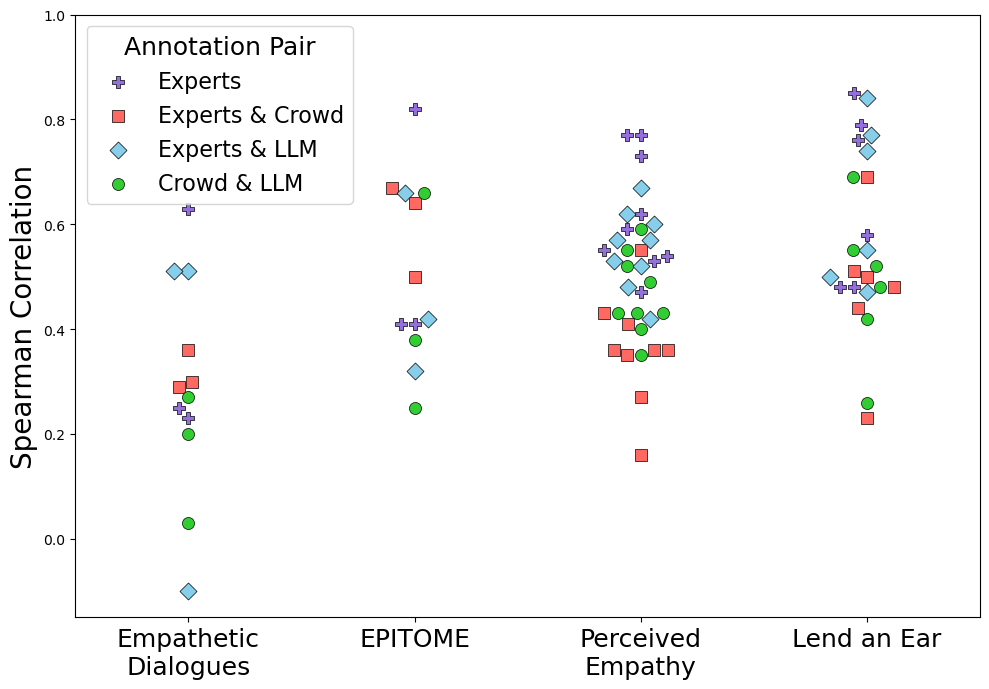

In [9]:
# Clean up the Annotator Pair labels first
label_mapping = {
    "('expert1', 'expert2')": "Experts",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Create a clean copy of the data with fixed labels
plot_data = table_3.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Spearman Correlation"] = plot_data["Spearman Correlation"].astype(float)

# Define marker mapping and colors
marker_mapping = {
    "Experts": "P",           # plus filled
    "Experts & Crowd": "s",   # square 
    "Experts & LLM": "D",     # diamond
    "Crowd & LLM": "o",       # circle
}

colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Spearman Correlation",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=10
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=75,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=18
)

plt.xlabel("")
plt.ylabel("Spearman Correlation", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=16,
    title_fontsize=18
)

plt.xlim(-0.5, 3.5)
plt.ylim(-0.15, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_spearman_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

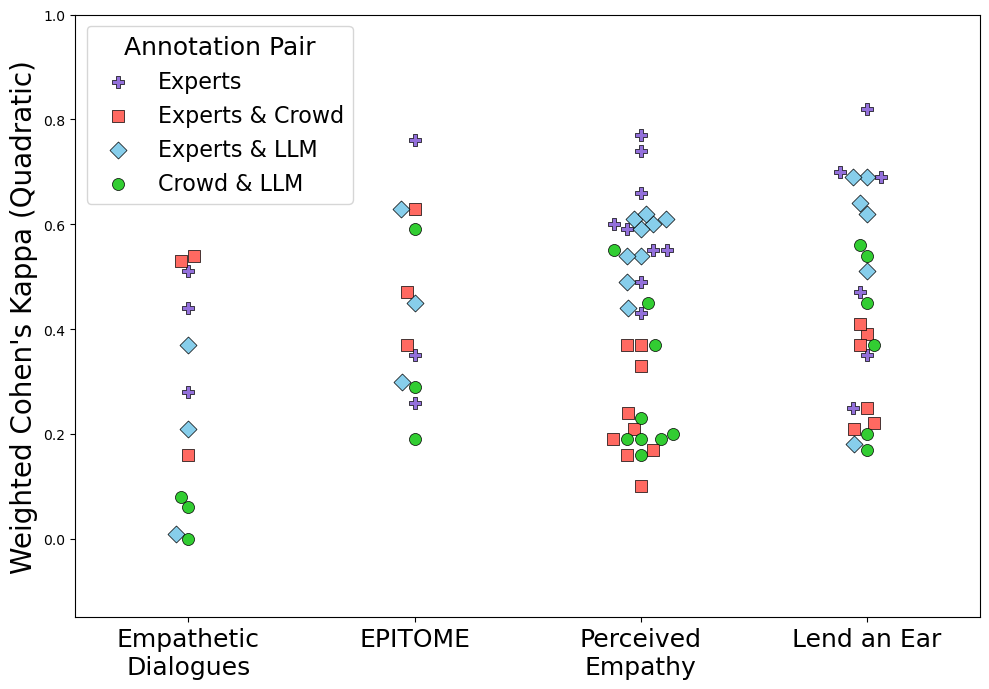

In [10]:
kappa = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")

kappa = kappa[
    (kappa["Annotator Pair"] != "('experts', 'gemini')")
    & (kappa["Annotator Pair"] != "('gemini', 'crowd')")
][
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Weighted Cohen's Kappa",
    ]
]
# Clean up the Annotator Pair labels first
label_mapping = {
    "('expert1', 'expert2')": "Experts",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Create a clean copy of the data with fixed labels
plot_data = kappa.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Weighted Cohen's Kappa"] = plot_data["Weighted Cohen's Kappa"].astype(float)

# Define marker mapping and colors
marker_mapping = {
    "Experts": "P",           # plus filled
    "Experts & Crowd": "s",   # square 
    "Experts & LLM": "D",     # diamond
    "Crowd & LLM": "o",       # circle
}

colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "RPG"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=10
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each hue's points with the correct marker and color
for hue in hue_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=75,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=18
)

plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=16,
    title_fontsize=18
)

plt.xlim(-0.5, 3.5)
plt.ylim(-0.15, 1)
plt.tight_layout()

plt.savefig("figs/beeswarm_plot_quadratic_cohens_kappa.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
###BAR PLOT OF SPEARMAN CORRELATION; APPENDIX FIGURE 1
def plot_gbars_with_ci(df, filename, dimensions):
    # Define labels for different annotator pair comparisons
    comparison_labels = {
        "('expert1', 'expert2')": "E1 vs. E2",
        "('experts', 'crowd')": "E vs. Crowd",
        "('experts', 'llm')": "E vs. LLM",
        "('llm', 'crowd')": "LLM vs. Crowd",
    }

    # Initialize dictionaries to store correlation values and confidence intervals for each comparison
    correlations = {comp: [] for comp in comparison_labels}
    confidence_intervals = {comp: [] for comp in comparison_labels}

    # Iterate over each comparison to extract relevant data from the DataFrame
    for comp in comparison_labels:
        # Filter data for the current annotator pair
        comp_data = df[df["Annotator Pair"] == comp]
        for dim in dimensions:
            # Filter data for the current dimension
            dim_data = comp_data[comp_data["Dimension"] == dim]
            # Append the Spearman Correlation value to the list
            correlations[comp].append(dim_data["Spearman Correlation"].values[0])
            # Calculate and append the confidence interval error
            ci_lower = dim_data["Fisher CI Lower"].values[0]
            ci_upper = dim_data["Fisher CI Upper"].values[0]
            confidence_intervals[comp].append(
                (ci_upper - ci_lower) / 2
            )  # Error is half the CI range

    # Create a figure and axis for the bar plot
    fig, ax = plt.subplots(figsize=(26, 7))

    # Define x positions for the bars
    x = np.arange(len(comparison_labels))

    # Format dimension labels for better readability
    dimension_labels = [
        dim.replace("m_", "").replace("level_", "").replace("_", "\n").title()
        for dim in dimensions
    ]

    colors = [
        "#8B008B",
        "#FA8072",
        "#FFA500",
        "#FFD700",
        "#40E0D0",
        "#1E90FF",
        "#2E8B57",
        "#BA55D3",
        "#708090",
    ]

    width = 0.1
    n_dims = len(dimensions)

    offsets = np.linspace(-(n_dims - 1) / 2.0, (n_dims - 1) / 2.0, n_dims)
    offsets *= width

    for i, dim in enumerate(dimensions):
        dim_correlation = [correlations[comp][i] for comp in comparison_labels]
        dim_ci = [confidence_intervals[comp][i] for comp in comparison_labels]

        # Plot the bar for the current dimension
        ax.bar(
            x + offsets[i],
            dim_correlation,
            width,
            yerr=dim_ci,
            label=dimension_labels[i],
            color=colors[i % len(colors)],
            capsize=5,  # Add caps to the error bars
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        ["E1 vs E2", "E vs Crowd", "E vs LLM", "LLM vs Crowd"], fontsize=16
    )
    ax.set_ylabel("Spearman Correlation", fontsize=20)
    ax.set_ylim(-0.5, 1.0)  # Set y-axis limits
    plt.xlim(-1, len(comparison_labels))  # Set x-axis limits

    ax.tick_params(axis="x", which="major", length=8, width=2, labelsize=20)
    ax.tick_params(axis="y", which="major", length=8, width=2, labelsize=20)

    # Add a legend to the plot
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=20,
        title="Dimensions",
        title_fontsize=20,
    )

    plt.tight_layout()
    plt.ylim(-0.35, 1.0)
    plt.savefig(filename, dpi=300)
    plt.show()


df = pd.read_csv("data/all_annotator_pairs_spearman_kappa.csv")
df["Annotator Pair"] = df["Annotator Pair"].astype(str)

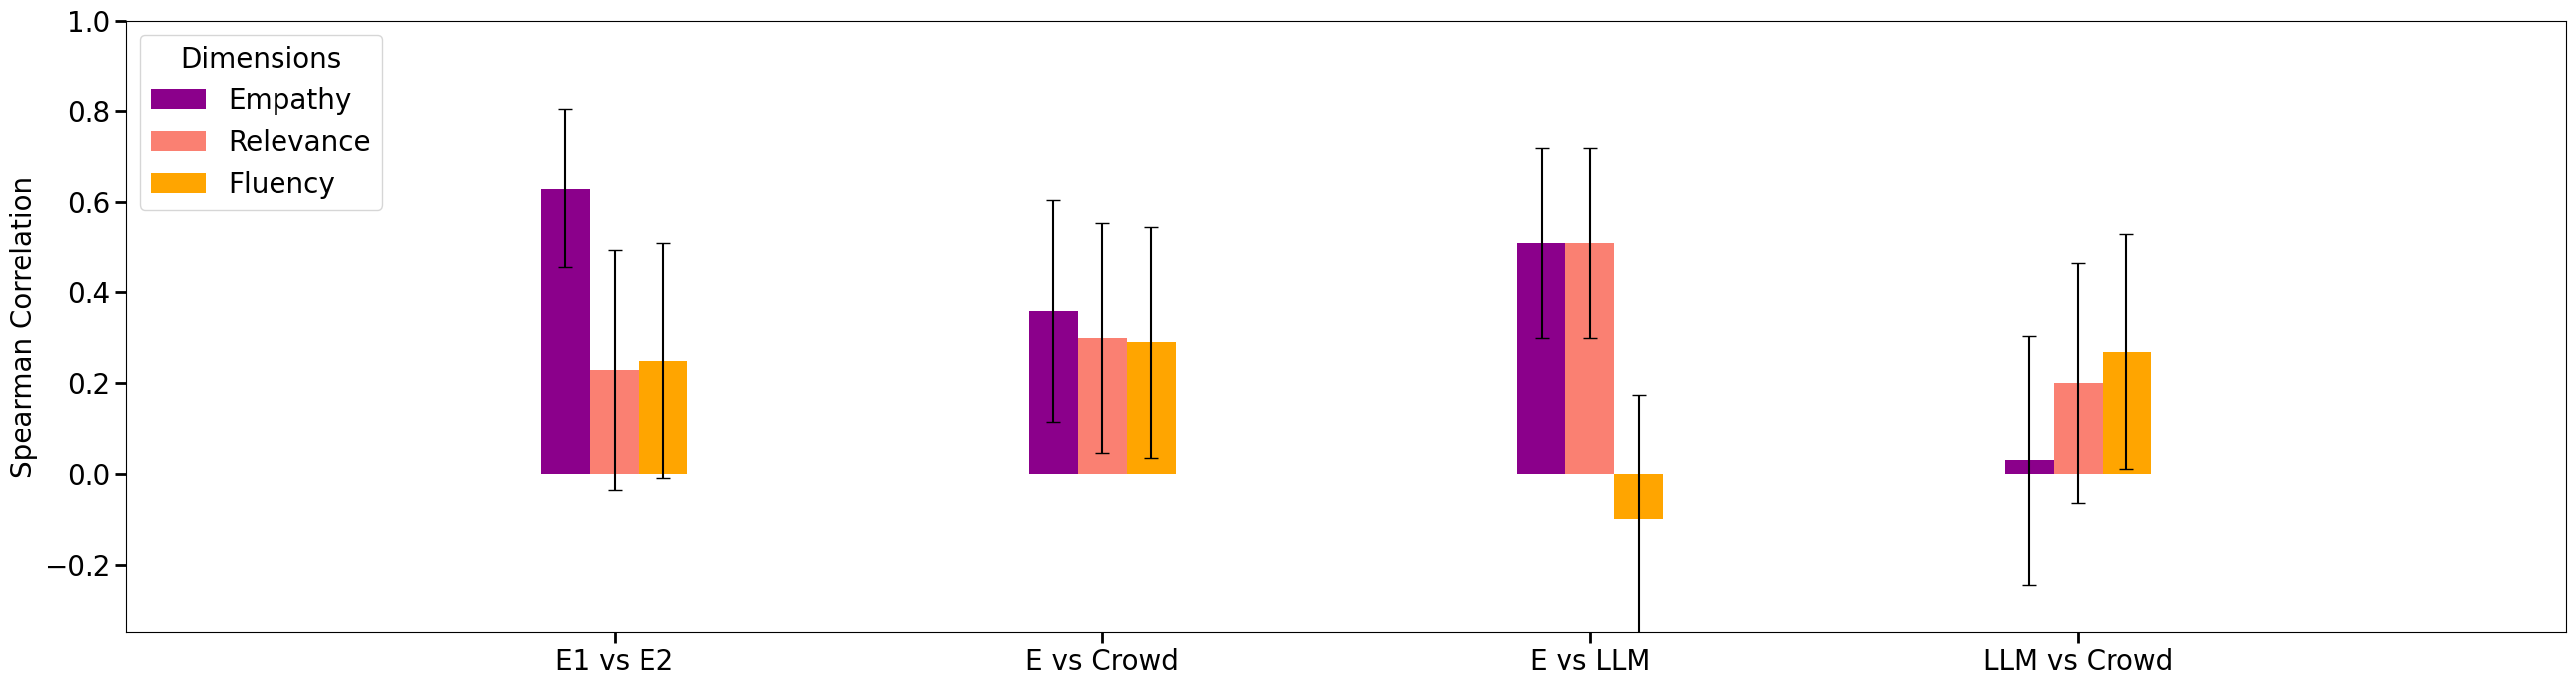

In [12]:
dimensions = ["empathy", "relevance", "fluency"]
plot_gbars_with_ci(df, "figs/empatheticdialogues_spearman.png", dimensions)

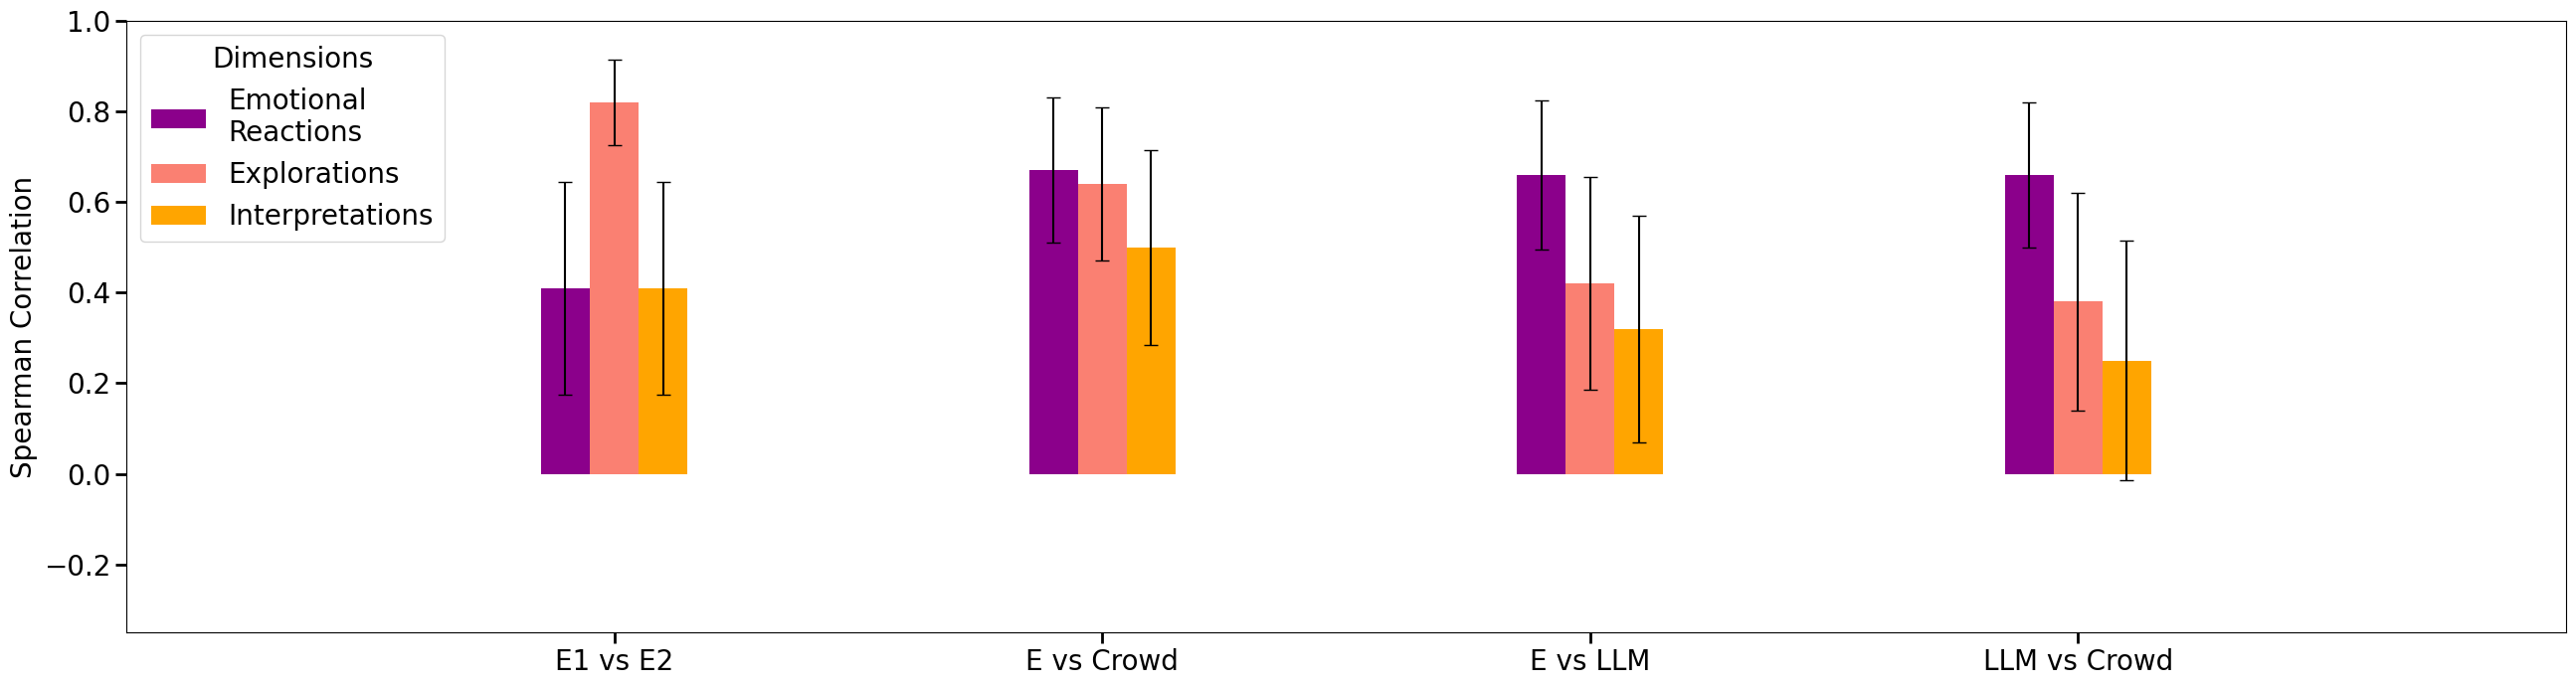

In [13]:
dimensions = [
    "level_emotional_reactions",
    "level_explorations",
    "level_interpretations",
]
plot_gbars_with_ci(df, "figs/epitome_spearman.png", dimensions)

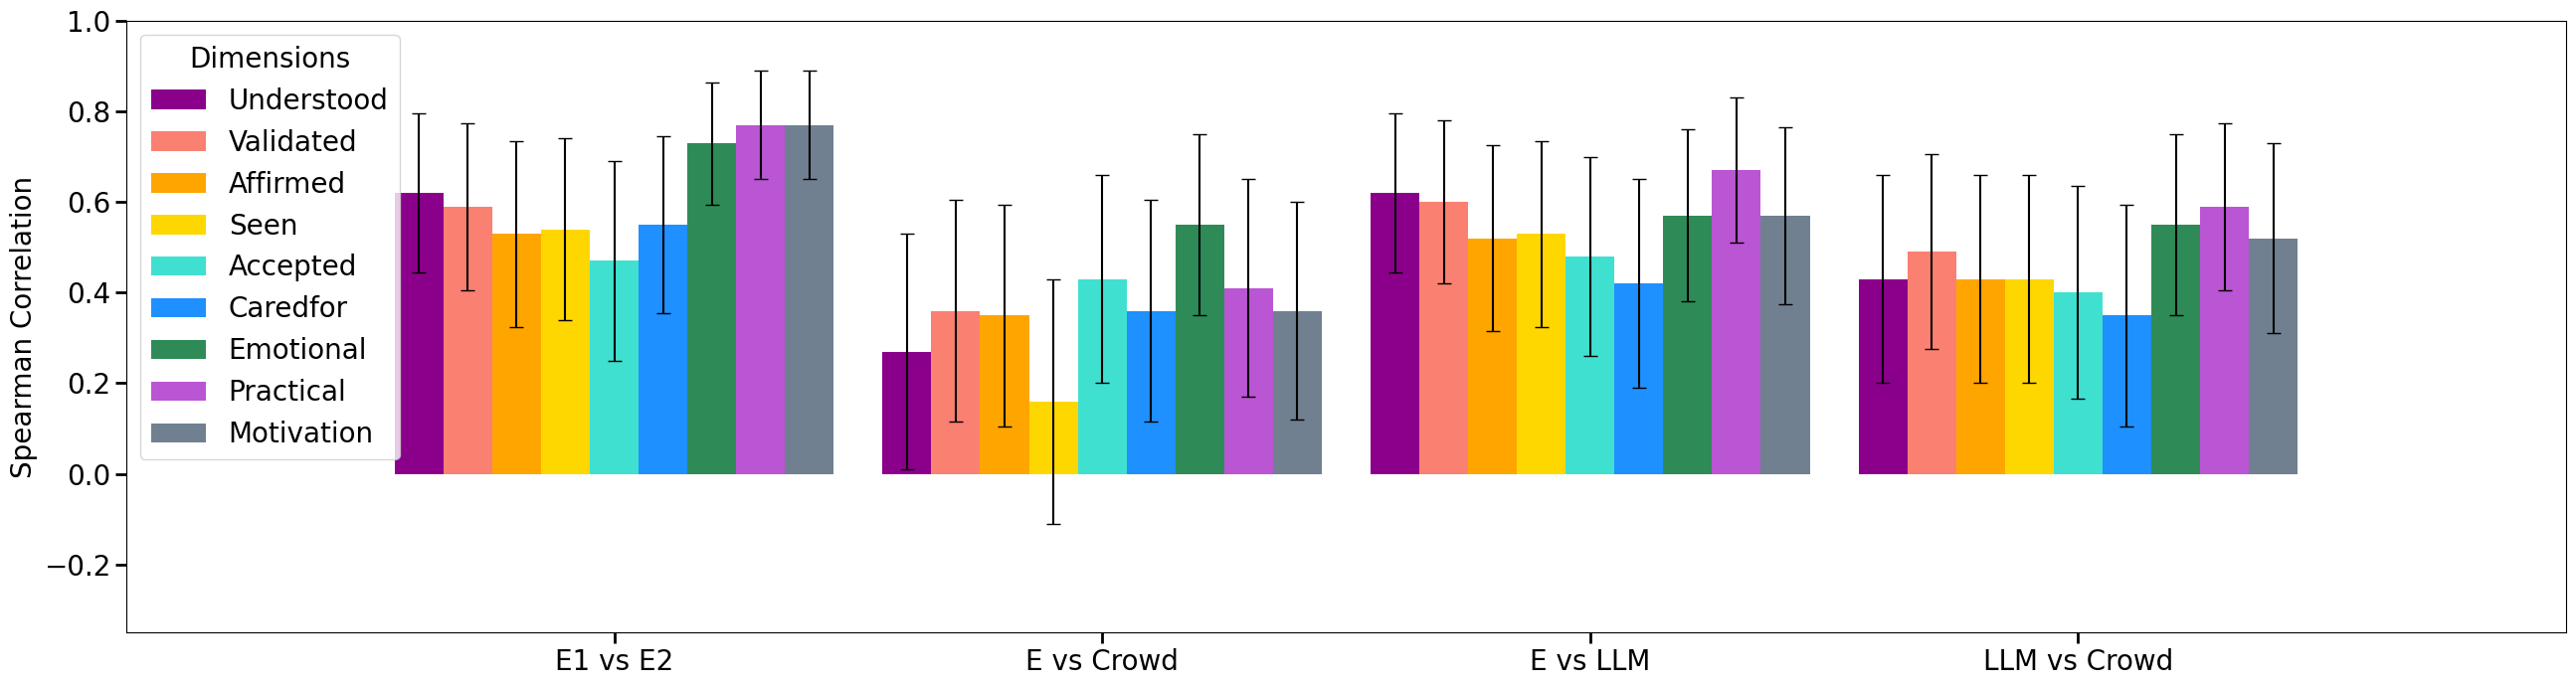

In [14]:
dimensions = [
    "m_understood",
    "m_validated",
    "m_affirmed",
    "m_seen",
    "m_accepted",
    "m_caredfor",
    "m_emotional",
    "m_practical",
    "m_motivation",
]
plot_gbars_with_ci(df, "figs/perceived_empathy_spearman.png", dimensions)

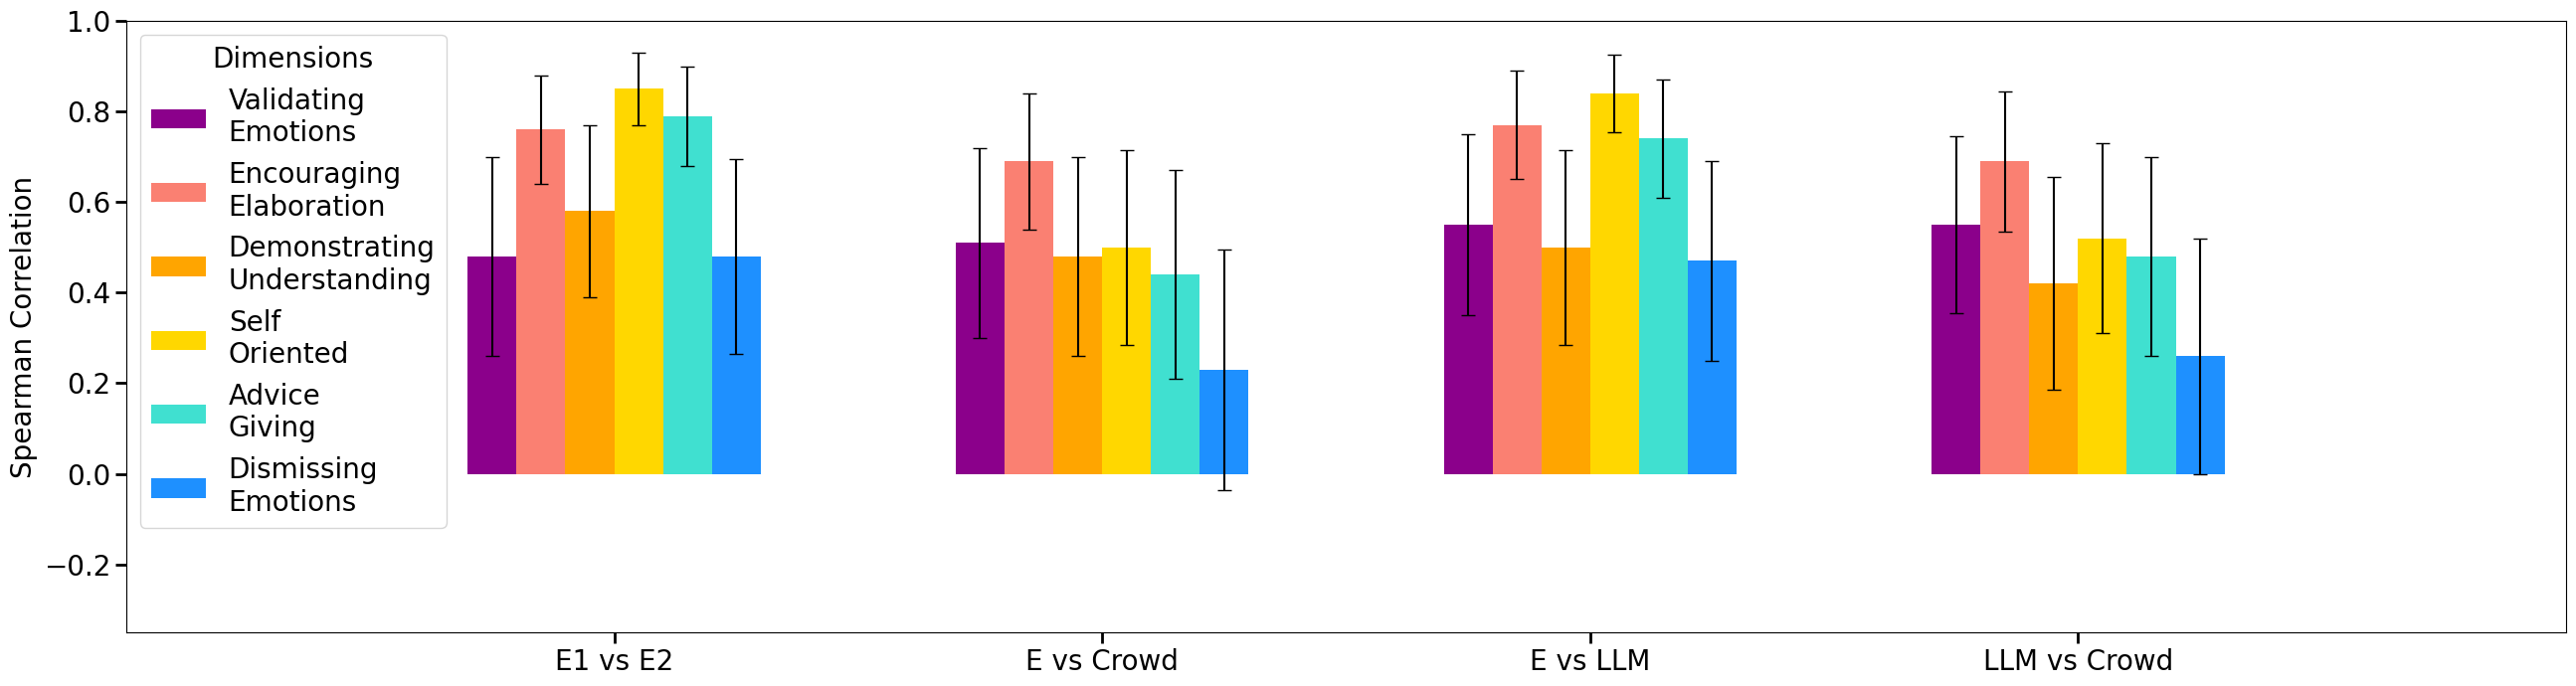

In [15]:
dimensions = [
    "validating_emotions",
    "encouraging_elaboration",
    "demonstrating_understanding",
    "self_oriented",
    "advice_giving",
    "dismissing_emotions",
]

plot_gbars_with_ci(df, "figs/lendanear_spearman.png", dimensions)

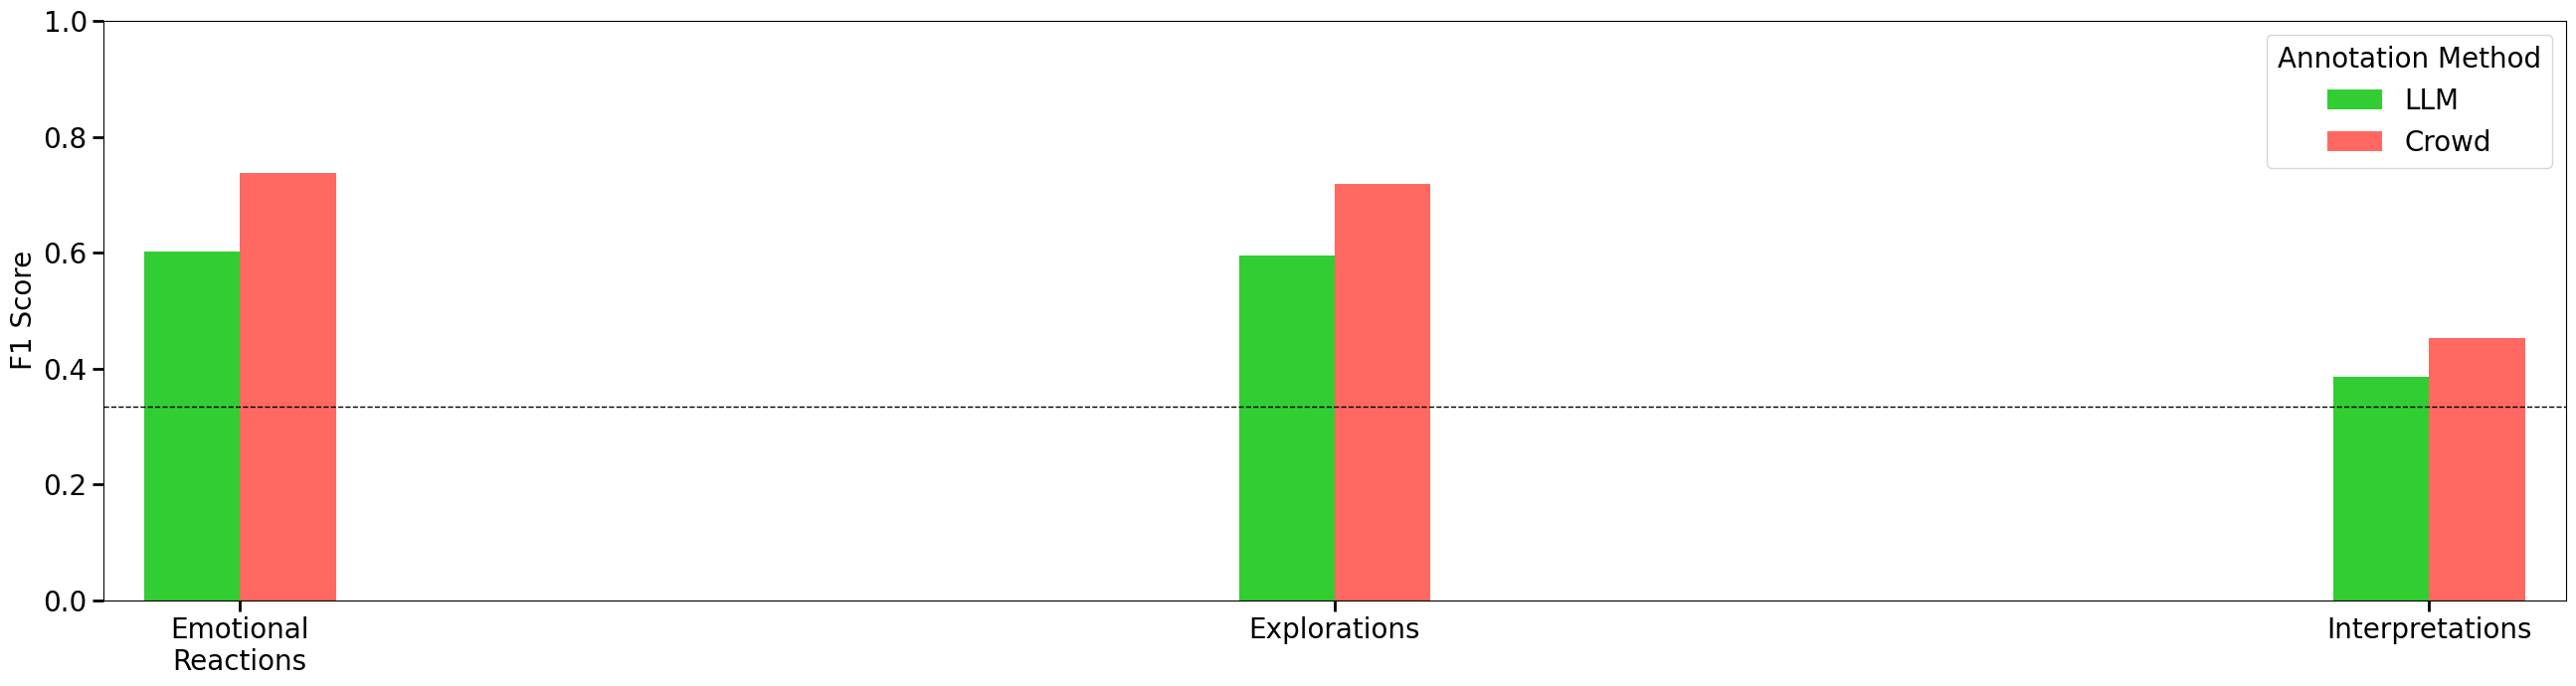

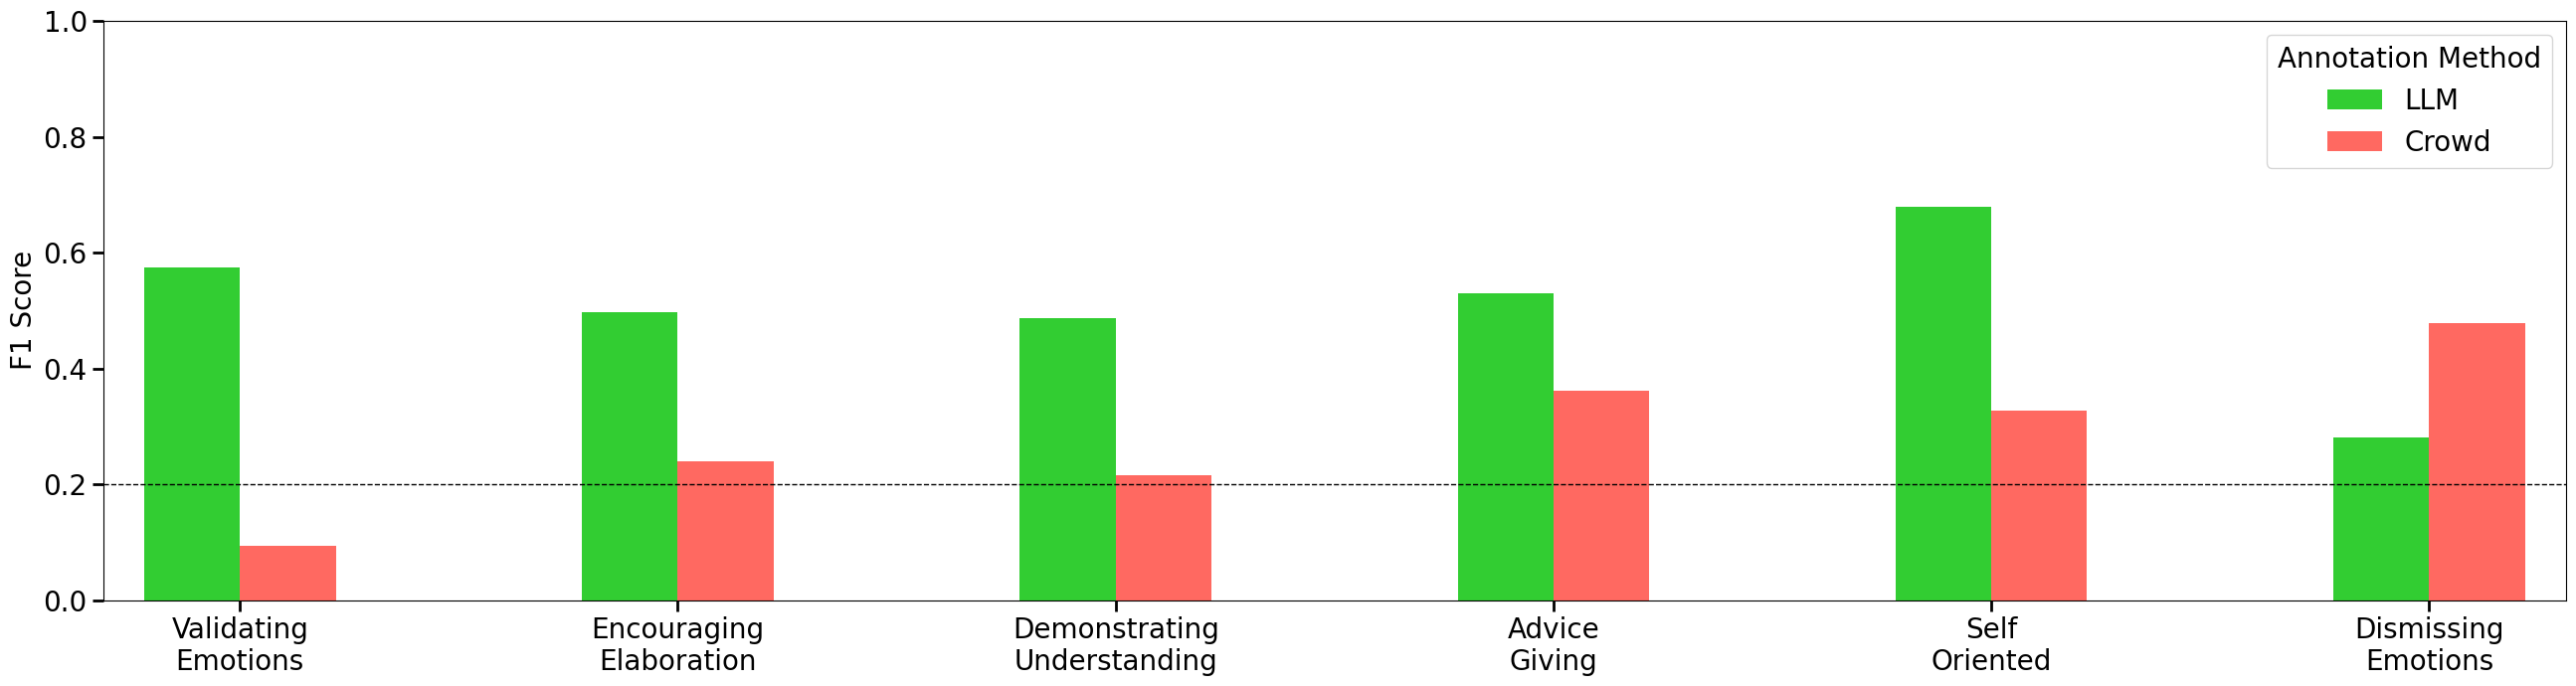

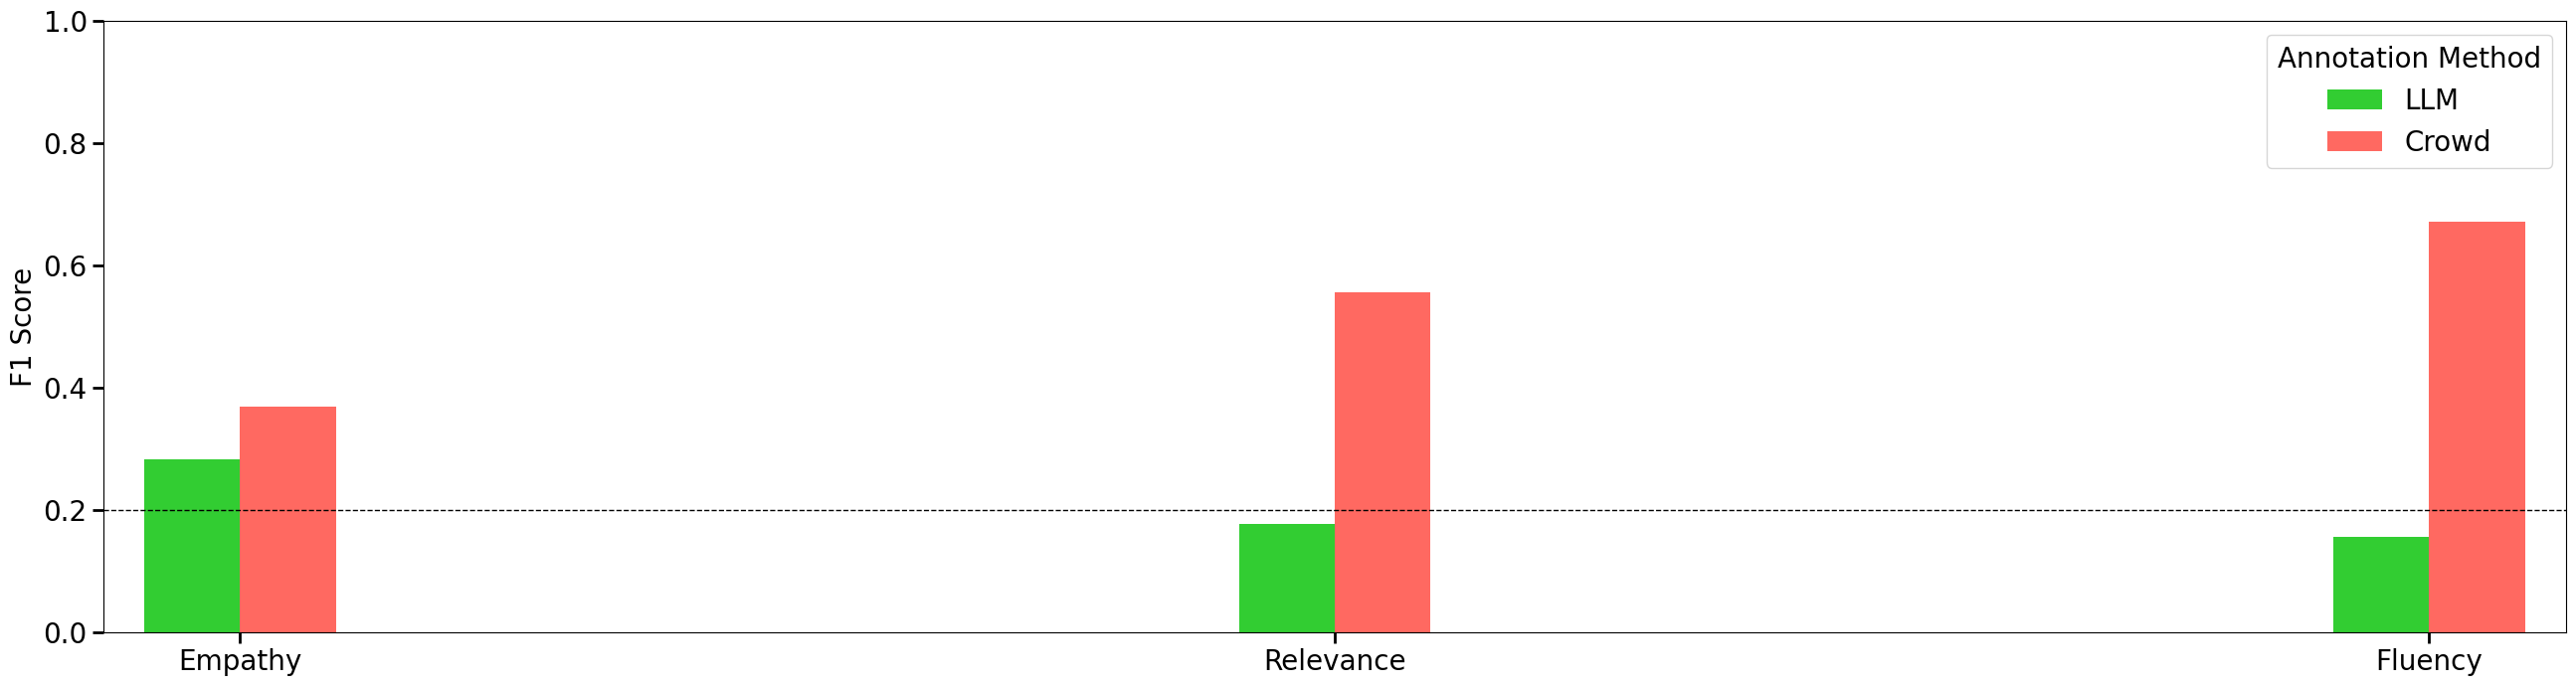

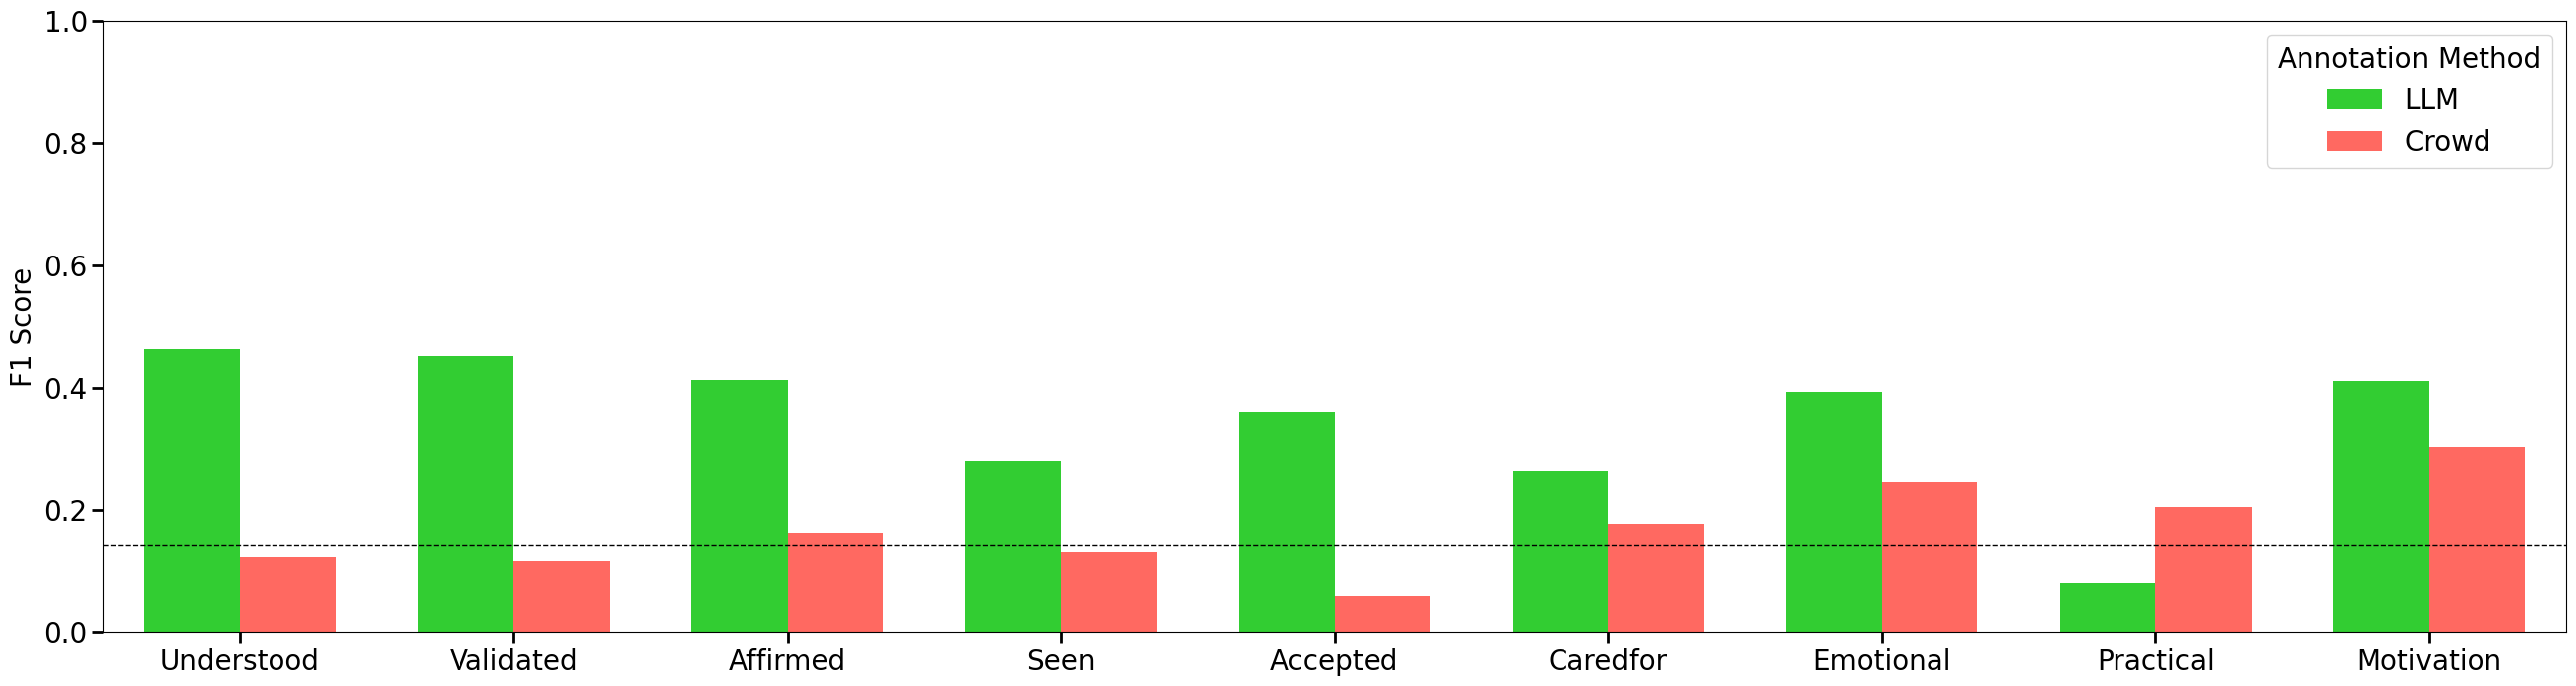

In [16]:
### F1 SCORES; APPENDIX FIGURE 
df = pd.read_csv("data/combined_annotations_across_methods_and_datasets.csv")

# Function to calculate F1 scores for each dimension within a dataset
def calculate_f1_scores(df, dimensions, method):
    scores = {}  
    for dim in dimensions:
        expert_ratings = df[df['annotation_method'] == 'experts'][dim].round(0)
        method_ratings = df[df['annotation_method'] == method][dim].round(0)
        
        # Calculate the weighted F1 score between expert and method ratings
        f1 = f1_score(expert_ratings, method_ratings, average='weighted')
        scores[dim] = {'F1 Score': f1}
    return scores  

# Dictionary to store F1 scores for each dataset and method
f1_scores = {
    'epitome': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['epitome']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['epitome']['dimensions'], 'crowd')
        }
    },
    'rpg': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['rpg']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['rpg']['dimensions'], 'crowd')
        }
    },
    'empatheticdialogues': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['empatheticdialogues']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['empatheticdialogues']['dimensions'], 'crowd')
        }
    },
    'perceived_empathy': {
        'scores': {
            'llm': calculate_f1_scores(df, datasets['perceived_empathy']['dimensions'], 'llm'),
            'crowd': calculate_f1_scores(df, datasets['perceived_empathy']['dimensions'], 'crowd')
        }
    }
}

# Function to plot F1 scores for each dataset
def plot_f1_scores(llm_scores, crowd_scores, title, max_dims=9):
    dimensions = list(llm_scores.keys())
    llm_f1 = [llm_scores[dim]['F1 Score'] for dim in dimensions]
    crowd_f1 = [crowd_scores[dim]['F1 Score'] for dim in dimensions]

    methods = ['LLM', 'Crowd']
    scores = [llm_f1, crowd_f1]

    n_dims = len(dimensions)
    n_methods = len(methods)

    fig, ax = plt.subplots(figsize=(26, 7))

    dimension_labels = [
        dim.replace('m_', '')
           .replace('level_', '')
           .replace('_', '\n')
           .title()
        for dim in dimensions
    ]

    x = np.linspace(0, max_dims - 1, n_dims)

    width = 0.35

    offsets = np.linspace(-(n_methods - 1) / 2.0, (n_methods - 1) / 2.0, n_methods) * width

    colors = ['#32CD32', '#FF6961']
    for i, (method, method_scores) in enumerate(zip(methods, scores)):
        ax.bar(
            x + offsets[i],
            method_scores,
            width,
            label=method,
            color=colors[i]
        )

    # Random guess thresholds for each dataset
    thresholds = {
        'F1 Scores for Epitome': 1/3,
        'F1 Scores for RPG': 1/5,
        'F1 Scores for Empathetic Dialogues': 1/5,
        'F1 Scores for Perceived Empathy': 1/7
    }
    if title in thresholds:
        ax.axhline(y=thresholds[title], color='black', linestyle='--', linewidth=1)

    # Axis labeling
    ax.set_ylabel('F1 Score', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(dimension_labels, fontsize=20)
    ax.tick_params(axis='x', which='major', length=8, width=2, labelsize=20)
    ax.tick_params(axis='y', which='major', length=8, width=2, labelsize=20)
    ax.set_ylim(0, 1.0)

    ax.set_xlim(-0.5, max_dims - 0.5)

    ax.legend(loc='upper right', frameon=True, fontsize=20,
              title='Annotation Method', title_fontsize=20)

    plt.tight_layout()
    plt.savefig(f"figs/{title.replace(' ', '_')}_f1_scores.png", dpi=300)
    plt.show()


# Plot F1 scores for each dataset
plot_f1_scores(
    f1_scores['epitome']['scores']['llm'], 
    f1_scores['epitome']['scores']['crowd'], 
    'F1 Scores for Epitome'
)

plot_f1_scores(
    f1_scores['rpg']['scores']['llm'], 
    f1_scores['rpg']['scores']['crowd'], 
    'F1 Scores for RPG'
)

plot_f1_scores(
    f1_scores['empatheticdialogues']['scores']['llm'], 
    f1_scores['empatheticdialogues']['scores']['crowd'], 
    'F1 Scores for Empathetic Dialogues'
)

plot_f1_scores(
    f1_scores['perceived_empathy']['scores']['llm'], 
    f1_scores['perceived_empathy']['scores']['crowd'], 
    'F1 Scores for Perceived Empathy'
)

/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_47891/892490628.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax,
/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_47891/892490628.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax,
/var/folders/5g/3xh1_kd17hqbtbqpfvrnfvs40000gn/T/ipykernel_47891/892490628.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax,


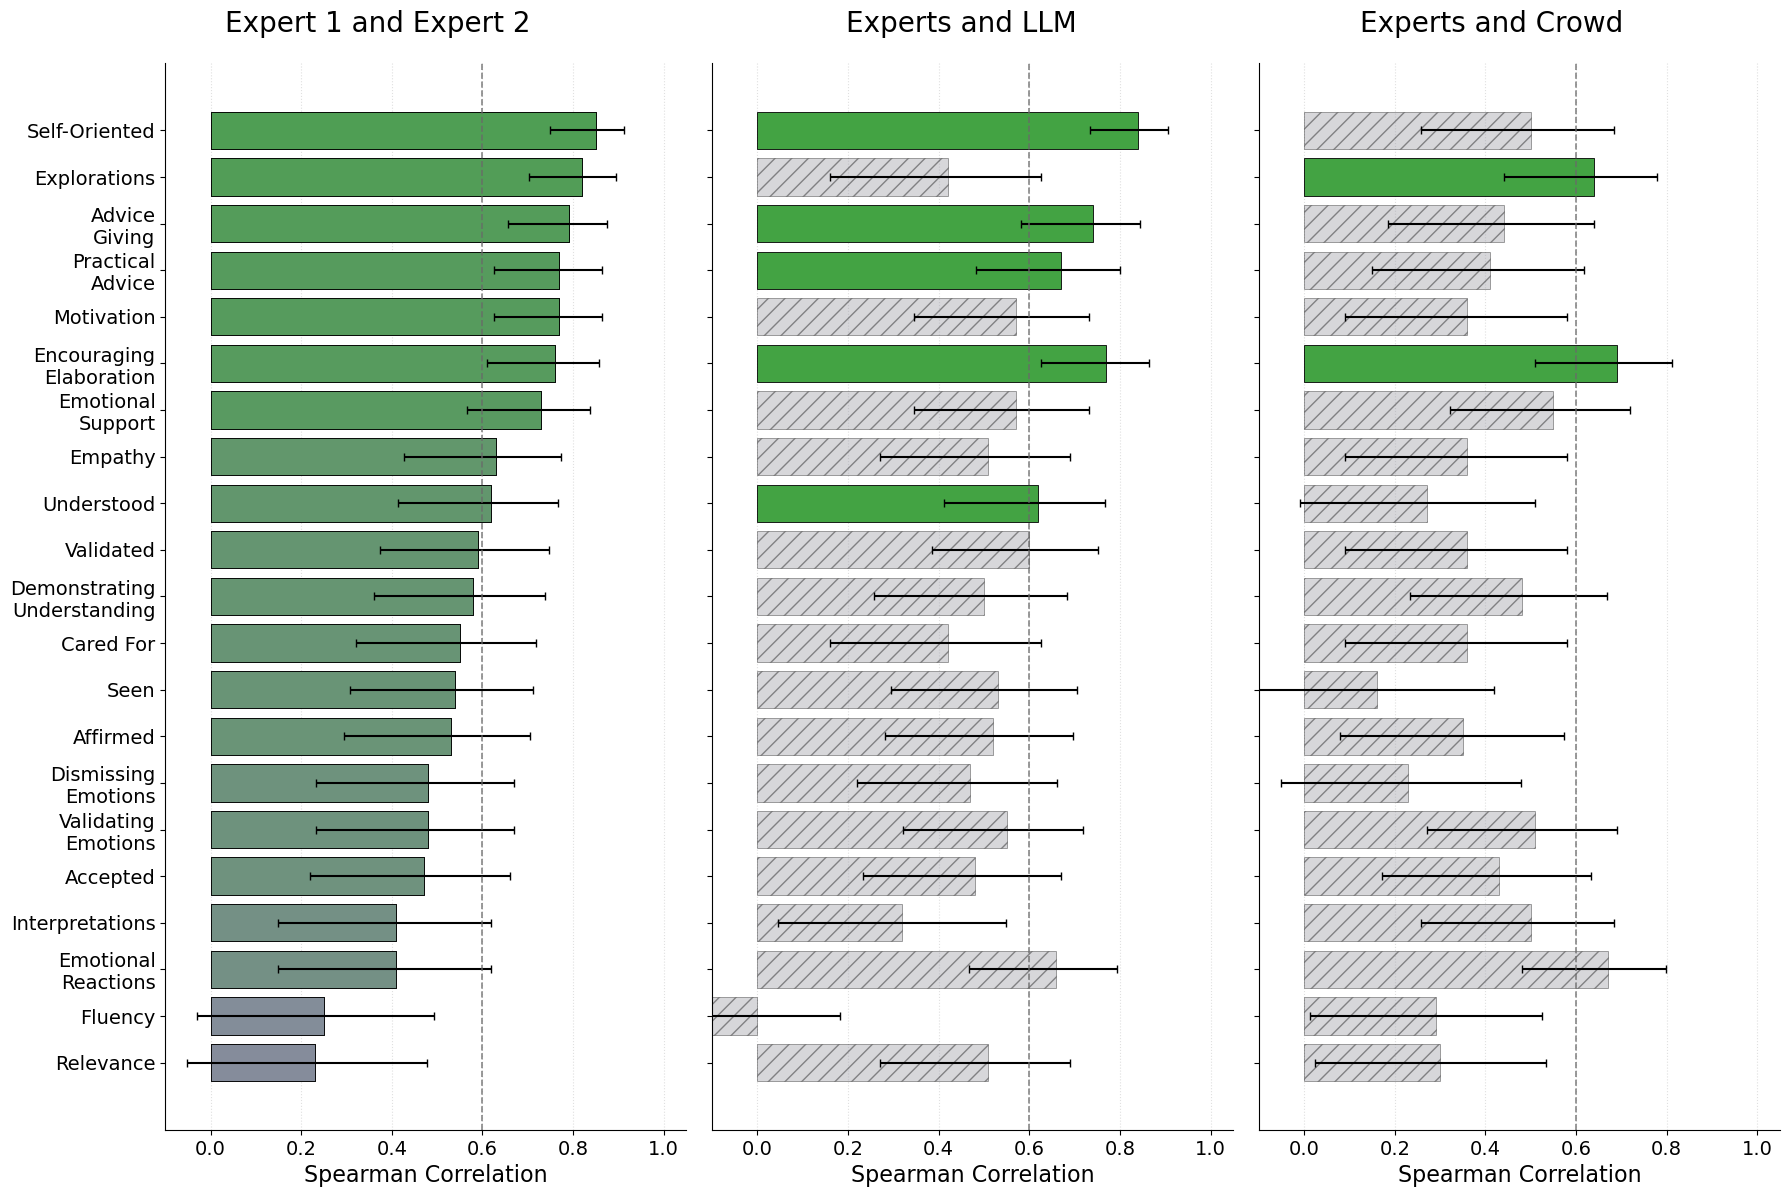

In [17]:
#CONTINUUM OF RELIABILITY
df = pd.read_csv("data/table_3.csv") 

dimension_map = {
    'relevance': 'Relevance', 'fluency': 'Fluency', 'level_interpretations': 'Interpretations',
    'level_emotional_reactions': 'Emotional\nReactions', 'm_accepted': 'Accepted',
    'validating_emotions': 'Validating\nEmotions', 'dismissing_emotions': 'Dismissing\nEmotions',
    'm_affirmed': 'Affirmed', 'm_seen': 'Seen', 'm_caredfor': 'Cared For',
    'demonstrating_understanding': 'Demonstrating\nUnderstanding', 'm_validated': 'Validated',
    'm_understood': 'Understood', 'empathy': 'Empathy', 'm_emotional': 'Emotional\nSupport',
    'encouraging_elaboration': 'Encouraging\nElaboration', 'm_motivation': 'Motivation',
    'm_practical': 'Practical\nAdvice', 'advice_giving': 'Advice\nGiving',
    'level_explorations': 'Explorations', 'self_oriented': 'Self-Oriented'
}
df['Dimension'] = df['Dimension'].replace(dimension_map)

pair_map = {
    "('expert1', 'expert2')": "Expert 1 and Expert 2", "('experts', 'llm')": "Experts and LLM",
    "('experts', 'crowd')": "Experts and Crowd", "('llm', 'crowd')": "LLM and Crowd"
}
df['Annotator Pair'] = df['Annotator Pair'].replace(pair_map)

expert_pair_filter = df['Annotator Pair'] == "Expert 1 and Expert 2"

expert_data = df.loc[expert_pair_filter, ['Dimension', 'Spearman Correlation']].copy()
expert_data['rank'] = expert_data['Spearman Correlation'].rank(method='min', ascending=False).astype(int)
expert_data = expert_data.sort_values('rank')
expert_corr_map = expert_data.set_index('Dimension')['Spearman Correlation']

rank_calc_df = df.loc[expert_pair_filter, ['Dimension', 'Spearman Correlation']].copy()
rank_calc_df['rank'] = rank_calc_df['Spearman Correlation'].rank(method='min', ascending=False).astype(int)
rank_calc_df = rank_calc_df.sort_values('rank')
df = df.merge(rank_calc_df[['Dimension', 'rank']], on='Dimension', how='left')

gray_start_color = np.array([0.6, 0.5, 0.75]) 
green_end_color = np.array([0.2, 0.7, 0.2])   

comparison_gray_color = (0.6, 0.6, 0.65) 
comparison_green_color = (0.2, 0.7, 0.2)
correlation_threshold = 0.6 
hatch_pattern = '//'
fig, axes = plt.subplots(1, 3, figsize=(18, 12), sharey=True) 

pairs_to_plot = ["Expert 1 and Expert 2", "Experts and LLM", "Experts and Crowd"]


for i, pair in enumerate(pairs_to_plot):
    ax = axes[i]
    pair_data = df[df['Annotator Pair'] == pair].copy()
    pair_data = pair_data.sort_values('rank', ascending=True)

    plot_colors = []
    plot_hatches = []

    if pair == "Expert 1 and Expert 2":
        correlations = pair_data['Spearman Correlation']
        min_corr = 0
        max_corr = 1
        norm_corrs = np.clip((correlations - min_corr) / (max_corr - min_corr), 0, 1)

        for norm_corr in norm_corrs:
            interpolated_color = gray_start_color * (1 - norm_corr) + green_end_color * norm_corr
            plot_colors.append(tuple(interpolated_color))
        plot_hatches = [None] * len(pair_data)

        sns.barplot(ax=ax, y='Dimension', x='Spearman Correlation', data=pair_data,
                    palette=plot_colors,
                    errorbar=None,
                    edgecolor='black',
                    linewidth=0.6,
                    hue='Dimension',
                    legend=False)

    else:
        for index, row in pair_data.iterrows():
            dimension = row['Dimension']
            expert_corr = expert_corr_map.get(dimension, 0)

            if expert_corr < correlation_threshold:
                plot_colors.append(comparison_gray_color)
                plot_hatches.append(hatch_pattern)
            else:
                correlation = row['Spearman Correlation']
                if correlation >= correlation_threshold:
                    plot_colors.append(comparison_green_color)
                    plot_hatches.append(None)
                else:
                    plot_colors.append(comparison_gray_color)
                    plot_hatches.append(hatch_pattern)
    
    rho_values = pair_data['Spearman Correlation'].values
    n_samples = 50
    rho_clamped = np.clip(rho_values, -0.999999, 0.999999)


    # Apply Fisher z-transformation (arctanh)
    z_values = np.arctanh(rho_clamped)

    std_err = 1 / np.sqrt(n_samples - 3)

    z_crit = stats.norm.ppf(0.975)
    z_lower = z_values - z_crit * std_err
    z_upper = z_values + z_crit * std_err

    rho_lower = np.tanh(z_lower)
    rho_upper = np.tanh(z_upper)

    lower_err_mag = np.maximum(0, rho_values - rho_lower)
    upper_err_mag = np.maximum(0, rho_upper - rho_values)
    plot_xerr = np.array([lower_err_mag, upper_err_mag])
    yerr = np.vstack([lower_err_mag, upper_err_mag])

    sns.barplot(ax=ax, 
                y='Dimension', 
                x='Spearman Correlation', 
                data=pair_data,
                palette=plot_colors,
                edgecolor='black',
                linewidth=0.6,
                errorbar=('ci', None),  
                err_kws={'linewidth': 1, 'color':'black'},
                capsize=3)
    
    ax.errorbar(x=pair_data['Spearman Correlation'],
            y=np.arange(len(pair_data)),
            xerr=yerr,
            fmt='none',
            color='black',
            capsize=3)

    for bar, hatch_type in zip(ax.patches, plot_hatches):
        if hatch_type:
            bar.set_hatch(hatch_type)
            bar.set_alpha(0.4)

    ax.text(.7, 1.05, f'{pair}', transform=ax.transAxes,
            fontsize=20, va='top', ha='right')

    ax.set_xlabel('Spearman Correlation', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlim(-0.1, 1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i == 0:
        ax.set_ylabel('', fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
    else:
        ax.set_ylabel('') 

    ax.axvline(x=correlation_threshold, color='dimgrey', linestyle='--', linewidth=1.2, alpha=0.8)

    ax.grid(axis='x', linestyle=':', alpha=0.7, color='lightgrey')
    ax.set_axisbelow(True) 

plt.tight_layout(w_pad=1.5) 
plt.savefig('figs/continuum_of_reliability.png', dpi=300)
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# Reading the generated data
rpg_cot_15 = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gemini-1.5-flash_0.csv')
rpg_cot_4o = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gpt-4o_0.csv')
rpg_cot_25 = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_gemini-2.5-pro-exp-03-25_0.csv')
rpg_cot_claude = pd.read_csv('data/Robustness Check Data/llm_rpg_cot_claude_0.csv')

rpg_fewshot_15 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-1.5-flash_0.csv')
rpg_fewshot_20 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-2.0-flash_0.csv')
rpg_fewshot_25 = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gemini-2.5-pro-exp-03-25_0.csv')
rpg_fewshot_4o = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_gpt-4o_0.csv')
rpg_fewshot_claude = pd.read_csv('data/Robustness Check Data/llm_rpg_fewshot_claude_0.csv')

perceived_empathy_cot_4o = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_gpt-4o_0.csv')
perceived_empathy_cot_25 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_gemini-2.5-pro-preview-03-25_0.csv')
perceived_empathy_cot_claude = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_cot_claude_0.csv')
perceived_empathy_cot_4o = perceived_empathy_cot_4o.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_cot_25 = perceived_empathy_cot_25.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_cot_claude = perceived_empathy_cot_claude.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})

perceived_empathy_15 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-1.5-flash_0.csv')
perceived_empathy_4o = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gpt-4o_0.csv')
perceived_empathy_25 = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_gemini-2.5-pro-preview-03-25_0.csv')
perceived_empathy_15 = perceived_empathy_15.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_4o = perceived_empathy_4o.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_25 = perceived_empathy_25.rename(columns={'conversation_id': 'id', 'm_care': 'm_caredfor', 'm_effort': 'm_motivation'})
perceived_empathy_claude = pd.read_csv('data/Robustness Check Data/llm_perceived_empathy_claude_0.csv')

empathetic_dialogues_cot_4o = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_gpt-4o_0.csv')
empathetic_dialogues_cot_25 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_gemini-2.5-pro-preview-03-25_0.csv')
empathetic_dialogues_cot_claude = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_cot_claude_0.csv')

empathetic_dialogues_cot_4o = empathetic_dialogues_cot_4o.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_cot_25 = empathetic_dialogues_cot_25.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_cot_claude = empathetic_dialogues_cot_claude.rename(columns={'conversation_id': 'conv_id'})

empathetic_dialogues_15 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-1.5-flash_0.csv')
empathetic_dialogues_4o = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gpt-4o_0.csv')
empathetic_dialogues_25 = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_gemini-2.5-pro-preview-03-25_0.csv')
empathetic_dialogues_claude = pd.read_csv('data/Robustness Check Data/llm_empatheticdialogues_claude_0.csv')
empathetic_dialogues_15 = empathetic_dialogues_15.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_4o = empathetic_dialogues_4o.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_25 = empathetic_dialogues_25.rename(columns={'conversation_id': 'conv_id'})
empathetic_dialogues_claude = empathetic_dialogues_claude.rename(columns={'conversation_id': 'conv_id'})


epitome_cot_15 = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gemini-1.5-flash_0.csv')
epitome_cot_4o = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gpt-4o_0.csv')
epitome_cot_25 = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_gemini-2.5-pro-preview-03-25_0.csv')
epitome_cot_claude = pd.read_csv('data/Robustness Check Data/llm_epitome_cot_claude_0.csv')
epitome_cot_15 = epitome_cot_15.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_4o = epitome_cot_4o.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_25 = epitome_cot_25.rename(columns={'conversation_id': 'conv_id'})
epitome_cot_claude = epitome_cot_claude.rename(columns={'conversation_id': 'conv_id'})

epitome_15 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-1.5-flash_0.csv')
epitome_4o = pd.read_csv('data/Robustness Check Data/llm_epitome_gpt-4o_0.csv')
epitome_25 = pd.read_csv('data/Robustness Check Data/llm_epitome_gemini-2.5-pro-preview-03-25_0.csv')
epitome_claude = pd.read_csv('data/Robustness Check Data/llm_epitome_claude_0.csv')
epitome_15 = epitome_15.rename(columns={'conversation_id': 'conv_id'})
epitome_4o = epitome_4o.rename(columns={'conversation_id': 'conv_id'})
epitome_25 = epitome_25.rename(columns={'conversation_id': 'conv_id'})
epitome_claude = epitome_claude.rename(columns={'conversation_id': 'conv_id'})

# 1. RPG Cot Claude updates
rpg_updates = [
    {'conversation_id': '20241031142343248156', 'encouraging_elaboration': 3},
    {'conversation_id': '20241031145050008738', 'dismissing_emotions': 4},
    {'conversation_id': '20241031125849757353', 'demonstrating_understanding': 2},
    {'conversation_id': '20241031145640298594', 'demonstrating_understanding': 2},
]
for update in rpg_updates:
    cid = update.pop('conversation_id')
    for col, val in update.items():
        rpg_cot_claude.loc[rpg_cot_claude['conversation_id'] == cid, col] = val

# 2. Epitome Cot Claude update
epitome_cot_claude.loc[epitome_cot_claude['sp_id'] == '9u1441', 'level_emotional_reactions'] = 1

# 3. Perceived Empathy Cot Claude updates
perceived_updates = [
    {'id': '6361560a2e3e691ad312fed2', 'm_accepted': 1},
    {'id': '5f81ead00afba52e71dcf414', 'm_affirmed': 6},
    {'id': '5e1c71e9114df8000dddf2d6', 'm_caredfor': 3},
    {'id': '629531cb501e6d23d9797050', 'm_validated': 1},
    {'id': '63386e75b02c4d7013c1198b', 'm_understood': 3, 'm_seen': 4},
    {'id': '6390fd9157f0dc14e247a0d6', 'm_caredfor': 2},
    {'id': '5fc3d41149c0c8728f07b95b', 'm_accepted': 3, 'm_seen': 2, 'm_affirmed': 3, 'm_validated': 3},
    {'id': '632e9aa62793c18a857aece4', 'm_caredfor': 4, 'm_validated': 3},
    {'id': '5dcf0b7cffc3d8063f916612', 'm_validated': 3},
    {'id': '63c13fcab1eda5bbe034a17c', 'm_accepted': 2},
    {'id': '614e7ad7ff5a0d785d5e550a', 'm_accepted': 3, 'm_understood': 3},
    {'id': '5cb489ff0cd1ed0017465d19', 'm_understood': 3},
    {'id': '5bcc2cee0ba8a400012592f9', 'm_understood': 2},
    {'id': '5d8e64ab4e055600157a3d90', 'm_understood': 3},
    {'id': '5bfd81fb2feab400014d9060', 'm_understood': 3, 'm_seen': 3},
    {'id': '60f4e3ab507bbb123f866e88', 'm_understood': 2, 'm_validated': 3},
    {'id': '6483b3662d98a34fa389dcd7', 'm_affirmed': 4},
    {'id': '638bb18e1bd657c755e5148f', 'm_accepted': 3},
    {'id': '608bfa04767191aa4d57bfd8', 'm_accepted': 3, 'm_affirmed': 3},
    {'id': '63f77fef0855adb7fa65873d', 'm_understood': 3},
    {'id': '6435d9620649d3801b71cc8b', 'm_understood': 3},
    {'id': '60fd080d5476f4a77211bafb', 'm_accepted': 2},
    {'id': '60fd462512ad2ae6071668f3', 'm_affirmed': 3},
    {'id': '5e84f020507cd30b367b2624', 'm_affirmed': 3, 'm_validated': 3},
    {'id': '62cbf51439a76e8fccd8a495', 'm_seen': 3, 'm_caredfor': 4},
    {'id': '5ee5e3b02eebe932ee9559c5', 'm_validated': 4},
]
for update in perceived_updates:
    pid = update.pop('id')
    for col, val in update.items():
        perceived_empathy_cot_claude.loc[perceived_empathy_cot_claude['id'] == pid, col] = val

# 4. Empathetic Dialogues Cot Claude updates
dialogue_updates = [
    {'conv_id': 'hit:8681_conv:17362', 'fluency': 4},
    {'conv_id': 'hit:1670_conv:3341', 'fluency': 5},
    {'conv_id': 'hit:4103_conv:8207', 'relevance': 5, 'fluency': 5},
    {'conv_id': 'hit:7797_conv:15594', 'fluency': 5},
    {'conv_id': 'hit:6759_conv:13519', 'relevance': 2},
    {'conv_id': 'hit:8311_conv:16622', 'relevance': 5},
    {'conv_id': 'hit:12276_conv:24553', 'relevance': 5},
]
for update in dialogue_updates:
    cid = update.pop('conv_id')
    for col, val in update.items():
        empathetic_dialogues_cot_claude.loc[empathetic_dialogues_cot_claude['conv_id'] == cid, col] = val


# Reading Expert Data
expert1_rpg = pd.read_csv('data/rpg/expert_ratings.csv')
expert2_rpg = pd.read_csv('data/rpg/expert2_ratings.csv')
expert3_rpg = pd.read_csv('data/rpg/expert3_ratings.csv')
expert3_rpg[['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions']]


expert1_pe = pd.read_csv('data/perceived_empathy/expert_ratings.csv')
expert2_pe = pd.read_csv('data/perceived_empathy/expert2_ratings.csv')
expert3_pe = pd.read_csv('data/perceived_empathy/expert3_ratings.csv')

cols = ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
        "m_caredfor", "m_emotional", "m_practical", "m_motivation"]

for col in cols:
    expert3_pe[col] = pd.to_numeric(expert3_pe[col], errors='coerce').astype('Int64')

expert1_ed = pd.read_csv('data/empatheticdialogues/expert_ratings.csv')
expert2_ed = pd.read_csv('data/empatheticdialogues/expert2_ratings.csv')
expert3_ed = pd.read_csv('data/empatheticdialogues/expert3_ratings.csv')
expert3_ed = pd.read_csv('data/empatheticdialogues/expert3_ratings.csv')
# expert3_ed = expert3_ed[1:].reset_index(drop = True)
# expert3_ed.rename(columns = {'Unnamed: 0': 'conv_id',
#                              'Likert scale: \n\n1 - Not at all\n2- Slightly\n3- Somewhat\n4 - Quite a bit\n5 - Very much': 'full_conversation',
#                              'Unnamed: 2': 'empathy',
#                              'Unnamed: 3': 'relevance',
#                              'Unnamed: 4': 'fluency'}, inplace = True)
# expert3_ed.drop(columns = 'full_conversation', inplace=True)
cols = ["empathy", "relevance", "fluency"]
for col in cols:
    expert3_ed[col] = pd.to_numeric(expert3_ed[col], errors='coerce').astype(int)


expert1_ept = pd.read_csv('data/epitome/expert_ratings.csv')
expert2_ept = pd.read_csv('data/epitome/expert2_ratings.csv')
expert3_ept = pd.read_csv('data/epitome/expert3_ratings.csv')
expert3_ept[['level_emotional_reactions', 'level_explorations', 'level_interpretations']].isna().any(axis = 1)


# Organizing the data
def order_by_column(df, column):
    return df.sort_values(by=column).reset_index(drop=True)

expert1_rpg = order_by_column(expert1_rpg, 'conversation_id')
expert2_rpg = order_by_column(expert2_rpg, 'conversation_id')
expert3_rpg = order_by_column(expert3_rpg, 'conversation_id')

expert1_pe = order_by_column(expert1_pe, 'id')
expert2_pe = order_by_column(expert2_pe, 'id')
expert3_pe = order_by_column(expert3_pe, 'id')

expert1_ed = order_by_column(expert1_ed, 'conv_id')
expert2_ed = order_by_column(expert2_ed, 'conv_id')
expert3_ed = order_by_column(expert3_ed, 'conv_id')

expert1_ept = order_by_column(expert1_ept, 'sp_id')
expert2_ept = order_by_column(expert2_ept, 'sp_id')
expert3_ept = order_by_column(expert3_ept, 'sp_id')

# Extracting Scores
def score_extraction(df, col, type):
    if type == 'rpg':
      scores = pd.DataFrame(columns = ['conversation_id', 'validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                                      'advice_giving', 'self_oriented', 'dismissing_emotions'])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'conversation_id': df.iloc[i, 1],
                                                      'validating_emotions': [int(str(df.iloc[i, 3])[-1])],
                                                          'encouraging_elaboration': [int(str(df.iloc[i, 4])[-1])],
                                                          'demonstrating_understanding': [int(str(df.iloc[i, 5])[-1])],
                                                          'advice_giving': [int(str(df.iloc[i, 6])[-1])],
                                                          'self_oriented': [int(str(df.iloc[i, 7])[-1])],
                                                          'dismissing_emotions': [int(str(df.iloc[i, 8])[-1])]
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 1])
    elif type == 'ept':
      scores = pd.DataFrame(columns = ['sp_id', 'level_emotional_reactions', 'level_explorations', 'level_interpretations'])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'sp_id': df.iloc[i, 0],
                                                      'level_emotional_reactions': [int(str(df.iloc[i, 3])[-1])],
                                                          'level_explorations': [int(str(df.iloc[i, 4])[-1])],
                                                          'level_interpretations': [int(str(df.iloc[i, 5])[-1])],
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 1])
    elif type == 'pe' : 
      scores = pd.DataFrame(columns = ["id", "m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor",
                                       "m_emotional", "m_practical", "m_motivation"])

      for i in range(len(df)):
          try:
              scores = pd.concat([scores, pd.DataFrame({'id': df.iloc[i, 0],
                                                      'm_understood': [int(str(df.iloc[i, 2])[-1])],
                                                          'm_validated': [int(str(df.iloc[i, 3])[-1])],
                                                          'm_affirmed': [int(str(df.iloc[i, 4])[-1])],
                                                          "m_seen": [int(str(df.iloc[i, 5])[-1])],
                                                          "m_accepted": [int(str(df.iloc[i, 6])[-1])],
                                                          "m_caredfor": [int(str(df.iloc[i, 7])[-1])],
                                                          "m_emotional": [int(str(df.iloc[i, 8])[-1])],
                                                          "m_practical": [int(str(df.iloc[i, 9])[-1])],
                                                          "m_motivation": [int(str(df.iloc[i, 10])[-1])]
                                                          })], ignore_index = True)
              scores = order_by_column(scores, col)
          except ValueError as e:
              print(df.iloc[i, 0]) 
    else:
        scores = pd.DataFrame(columns = ["conv_id", "empathy", "relevance", "fluency"])
        for i in range(len(df)):
          try:
            scores = pd.concat([scores, pd.DataFrame({'conv_id': df.iloc[i, 0],
                                                        'empathy': [int(str(df.iloc[i, 2])[-1])],
                                                            'relevance': [int(str(df.iloc[i, 3])[-1])],
                                                            'fluency': [int(str(df.iloc[i, 4])[-1])],
                                                            })], ignore_index = True)
            scores = order_by_column(scores, col)
          except ValueError as e:
            print(df.iloc[i, 0])
    return scores

rpg_cot_15 = score_extraction(rpg_cot_15, 'conversation_id', 'rpg')
rpg_cot_4o = score_extraction(rpg_cot_4o, 'conversation_id', 'rpg')
rpg_cot_25 = score_extraction(rpg_cot_25, 'conversation_id', 'rpg')
rpg_cot_claude = score_extraction(rpg_cot_claude, 'conversation_id', 'rpg')

rpg_fewshot_15 = score_extraction(rpg_fewshot_15, 'conversation_id', 'rpg')
rpg_fewshot_20 = score_extraction(rpg_fewshot_20, 'conversation_id', 'rpg')
rpg_fewshot_4o = score_extraction(rpg_fewshot_4o, 'conversation_id', 'rpg')
rpg_fewshot_25 = score_extraction(rpg_fewshot_25, 'conversation_id', 'rpg')
rpg_fewshot_claude = score_extraction(rpg_fewshot_claude, 'conversation_id', 'rpg')

epitome_cot_15 = score_extraction(epitome_cot_15, 'sp_id', 'ept')
epitome_cot_4o = score_extraction(epitome_cot_4o, 'sp_id', 'ept')
epitome_cot_25 = score_extraction(epitome_cot_25, 'sp_id', 'ept')
epitome_cot_claude = score_extraction(epitome_cot_claude, 'sp_id', 'ept')

epitome_15 = score_extraction(epitome_15, 'sp_id', 'ept')
epitome_4o = score_extraction(epitome_4o, 'sp_id', 'ept')
epitome_25 = score_extraction(epitome_25, 'sp_id','ept')
epitome_claude = score_extraction(epitome_claude, 'sp_id', 'ept')

perceived_empathy_15 = score_extraction(perceived_empathy_15, 'id', 'pe')
perceived_empathy_4o = score_extraction(perceived_empathy_4o, 'id', 'pe')
perceived_empathy_25 = score_extraction(perceived_empathy_25, 'id', 'pe')
perceived_empathy_claude = score_extraction(perceived_empathy_claude, 'id', 'pe')

perceived_empathy_cot_4o = score_extraction(perceived_empathy_cot_4o, 'id', 'pe')
perceived_empathy_cot_25 = score_extraction(perceived_empathy_cot_25, 'id', 'pe')
perceived_empathy_cot_claude = score_extraction(perceived_empathy_cot_claude, 'id', 'pe')

empathetic_dialogues_15 = score_extraction(empathetic_dialogues_15, 'conv_id', 'ed')
empathetic_dialogues_4o = score_extraction(empathetic_dialogues_4o, 'conv_id', 'ed')
empathetic_dialogues_25 = score_extraction(empathetic_dialogues_25, 'conv_id','ed')
empathetic_dialogues_claude = score_extraction(empathetic_dialogues_claude, 'conv_id', 'ed')

empathetic_dialogues_cot_4o = score_extraction(empathetic_dialogues_cot_4o, 'conv_id', 'ed')
empathetic_dialogues_cot_25 = score_extraction(empathetic_dialogues_cot_25, 'conv_id','ed')
empathetic_dialogues_cot_claude = score_extraction(empathetic_dialogues_cot_claude, 'conv_id', 'ed')

# Calculating Mean Expert Data
def mean_experts(e1, e2, e3, dims, col):
  order_by_column(e1, col)
  order_by_column(e2, col)
  order_by_column(e3, col)
  
  mean_df = e1.copy()

  for d in dims:
    mean_df[d] = (e1[d] + e2[d] + e3[d]) / 3

  return mean_df

def mode_experts(e1, e2, e3, dims, col):
  order_by_column(e1, col)
  order_by_column(e2, col)
  order_by_column(e3, col)
  
  mode_df = e1.copy()

  for d in dims:
    stacked = np.vstack([e1[d], e2[d], e3[d]]).T  # Shape (n_rows, 3)
    mode_vals, _ = stats.mode(stacked, axis=1, keepdims=False)
    mode_df[d] = mode_vals

  return mode_df 

experts_rpg = mean_experts(expert1_rpg, expert2_rpg, expert3_rpg,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'conversation_id')

experts_pe = mean_experts(expert1_pe, expert2_pe, expert3_pe,
                          ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor", "m_emotional", "m_practical",
                            "m_motivation"], 'id')

experts_ed = mean_experts(expert1_ed, expert2_ed, expert3_ed,
                          ["empathy", "fluency", "relevance"], 'conv_id')

experts_ept = mean_experts(expert1_ept, expert2_ept, expert3_ept,
                           ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'sp_id')

experts_mode_rpg = mode_experts(expert1_rpg, expert2_rpg, expert3_rpg,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'conversation_id')

experts_mode_pe = mode_experts(expert1_pe, expert2_pe, expert3_pe,
                          ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted", "m_caredfor", "m_emotional", "m_practical",
                            "m_motivation"], 'id')

experts_mode_ed = mode_experts(expert1_ed, expert2_ed, expert3_ed,
                          ["empathy", "fluency", "relevance"], 'conv_id')

experts_mode_ept = mode_experts(expert1_ept, expert2_ept, expert3_ept,
                           ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'sp_id')

# calculating spearman rank correlation and weighted cohen's kappa
def corrs(e1, e2, e3, es, gemini25, gpt, claude, dims, df):
  corr_df = pd.DataFrame(columns = ['Dataset',
                                    'Dimension', 
                                    'Experts 1 & 2 Spearman Rank Correlation',
                                    'Experts 1 & 3 Spearman Rank Correlation',
                                    'Experts 2 & 3 Spearman Rank Correlation', 
                                    'Gemini 2.5 Pro Spearman Rank Correlation',
                                    'GPT 4o Spearman Rank Correlation',
                                    'Claude Spearman Rank Correlation',                                      
                                    'Experts 1 & 2 Weighted Cohen\'s Kappa', 
                                    'Experts 1 & 3 Weighted Cohen\'s Kappa', 
                                    'Experts 2 & 3 Weighted Cohen\'s Kappa', 
                                    'Gemini 2.5 Pro Weighted Cohen\'s Kappa',
                                    'GPT 4o Weighted Cohen\'s Kappa',
                                    'Claude Weighted Cohen\'s Kappa'])
  for d in dims:
    mask = es[d].notna() & gpt[d].notna()
    new_row = {
            'Dataset': df,
            'Dimension': d,
            'Experts 1 & 2 Spearman Rank Correlation': np.round(e1[d].corr(e2[d], method = 'spearman'), 2),
            'Experts 1 & 3 Spearman Rank Correlation': np.round(e1[d][mask].corr(e3[d][mask], method = 'spearman'), 2),
            'Experts 2 & 3 Spearman Rank Correlation': np.round(e2[d][mask].corr(e3[d][mask], method = 'spearman'), 2),
            'Gemini 2.5 Pro Spearman Rank Correlation': np.round(es[d][mask].corr(gemini25[d][mask].astype(int), method = 'spearman'), 2),
            'GPT 4o Spearman Rank Correlation': np.round(es[d][mask].corr(gpt[d][mask].astype(int), method = 'spearman'),2),
            'Claude Spearman Rank Correlation': np.round(es[d][mask].corr(claude[d][mask].astype(int), method ='spearman'), 2),              
            'Experts 1 & 2 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e1[d] + 0.5).astype(int), np.floor(e2[d] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Experts 1 & 3 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e1[d][mask] + 0.5).astype(int), np.floor(e3[d][mask] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Experts 2 & 3 Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(e2[d][mask] + 0.5).astype(int), np.floor(e3[d][mask] + 0.5).astype(int), weights= 'quadratic'), 2),
            'Gemini 2.5 Pro Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(es[d][mask].astype(int), gemini25[d][mask].astype(int), weights= 'quadratic'), 2),
            'GPT 4o Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(es[d][mask].astype(int) + 0.5).astype(int), np.floor(gpt[d][mask].astype(int) + 0.5).astype(int), weights= 'quadratic'), 2),
            'Claude Weighted Cohen\'s Kappa': np.round(cohen_kappa_score(np.floor(es[d][mask].astype(int)+ 0.5).astype(int), np.floor(claude[d][mask].astype(int) + 0.5).astype(int), weights = 'quadratic'), 2)            
          }
    corr_df = pd.concat([corr_df, pd.DataFrame([new_row])], ignore_index=True)
  
  return corr_df

rpg_fewshot_corr = corrs(expert1_rpg, expert2_rpg, expert3_rpg, experts_rpg, rpg_fewshot_25, rpg_fewshot_4o, rpg_fewshot_claude,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'RPG Fewshot')

rpg_cot_corr = corrs(expert1_rpg, expert2_rpg, expert3_rpg, experts_rpg, rpg_cot_25, rpg_cot_4o, rpg_cot_claude,
                           ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions'], 'RPG CoT')

perceived_empathy_corr = corrs(expert1_pe, expert2_pe, expert3_pe, experts_pe, perceived_empathy_25, perceived_empathy_4o, perceived_empathy_claude,
                               ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
                                "m_caredfor", "m_emotional", "m_practical", "m_motivation"], 'Perceived Empathy')

perceived_empathy_cot_corr = corrs(expert1_pe, expert2_pe, expert3_pe, experts_pe, perceived_empathy_cot_25, perceived_empathy_cot_4o, perceived_empathy_cot_claude,
                               ["m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
                                "m_caredfor", "m_emotional", "m_practical", "m_motivation"], 'Perceived Empathy CoT')

empathetic_dialogues_corr = corrs(expert1_ed, expert2_ed, expert3_ed, experts_ed, empathetic_dialogues_25, empathetic_dialogues_4o, empathetic_dialogues_claude,
                                  ["empathy", "relevance", "fluency"], 'Empathetic Dialogues')

empathetic_dialogues_cot_corr = corrs(expert1_ed, expert2_ed, expert3_ed, experts_ed, empathetic_dialogues_cot_25, empathetic_dialogues_cot_4o, empathetic_dialogues_cot_claude,
                                  ["empathy", "relevance", "fluency"], 'Empathetic Dialogues CoT')

epitome_corr = corrs(expert1_ept, expert2_ept, expert3_ept, experts_ept, epitome_25, epitome_4o, epitome_claude, 
                      ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'EPITOME Fewshot')

epitome_cot_corr = corrs(expert1_ept, expert2_ept, expert3_ept, experts_ept, epitome_cot_25, epitome_cot_4o, epitome_cot_claude,
                      ["level_emotional_reactions", "level_explorations", "level_interpretations"], 'EPITOME CoT')

#%%
final_table = pd.concat([rpg_fewshot_corr, rpg_cot_corr, empathetic_dialogues_corr, empathetic_dialogues_cot_corr, epitome_corr, epitome_cot_corr])
final_table.to_csv('replication_analysis_final_table.csv')
final_table

,Dataset,Dimension,Experts 1 & 2 Spearman Rank Correlation,Experts 1 & 3 Spearman Rank Correlation,Experts 2 & 3 Spearman Rank Correlation,Gemini 2.5 Pro Spearman Rank Correlation,GPT 4o Spearman Rank Correlation,Claude Spearman Rank Correlation,Experts 1 & 2 Weighted Cohen's Kappa,Experts 1 & 3 Weighted Cohen's Kappa,Experts 2 & 3 Weighted Cohen's Kappa,Gemini 2.5 Pro Weighted Cohen's Kappa,GPT 4o Weighted Cohen's Kappa,Claude Weighted Cohen's Kappa
0,RPG Fewshot,validating_emotions,0.48,0.57,0.59,0.75,0.70,0.70,0.25,0.39,0.58,0.57,0.54,0.69
1,RPG Fewshot,encouraging_elaboration,0.76,0.79,0.76,0.87,0.74,0.82,0.69,0.67,0.75,0.79,0.69,0.78
2,RPG Fewshot,demonstrating_understanding,0.58,0.27,0.47,0.57,0.50,0.40,0.47,0.36,0.44,0.57,0.40,0.43
3,RPG Fewshot,advice_giving,0.79,0.62,0.77,0.83,0.78,0.72,0.70,0.55,0.72,0.49,0.55,0.32
4,RPG Fewshot,self_oriented,0.85,0.56,0.61,0.89,0.87,0.92,0.82,0.70,0.55,0.60,0.54,0.57
5,RPG Fewshot,dismissing_emotions,0.48,0.47,0.40,0.57,0.51,0.46,0.35,0.50,0.51,0.14,0.13,0.15
0,RPG CoT,validating_emotions,0.48,0.57,0.59,0.75,0.78,0.73,0.25,0.39,0.58,0.45,0.32,0.52
1,RPG CoT,encouraging_elaboration,0.76,0.79,0.76,0.82,0.69,0.89,0.69,0.67,0.75,0.63,0.46,0.65
2,RPG CoT,demonstrating_understanding,0.58,0.27,0.47,0.79,0.33,0.60,0.47,0.36,0.44,0.61,0.13,0.42
3,RPG CoT,advice_giving,0.79,0.62,0.77,0.85,0.60,0.72,0.70,0.55,0.72,0.52,0.27,0.26


In [2]:
# expert3_pe[expert3_pe.isna().any(axis=1)]

# expert3_rpg[expert3_rpg[['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding', 'advice_giving', 'self_oriented', 'dismissing_emotions']].isna().any(axis = 1)]
# # expert3_ept[expert3_ept[['level_emotional_reactions', 'level_explorations', 'level_interpretations']].isna().any(axis = 1)]
# # expert3_ept.isna()

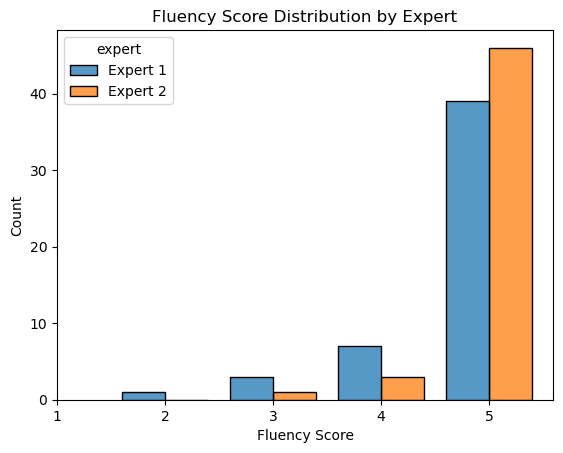

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine data into long format
df_fluency = pd.DataFrame({
    'fluency': pd.concat([expert1_ed['fluency'], expert2_ed['fluency']], ignore_index=True),
    'expert': ['Expert 1'] * len(expert1_ed) + ['Expert 2'] * len(expert2_ed)
})

# Drop NaNs
df_fluency = df_fluency.dropna()

# Plot histogram
sns.histplot(data=df_fluency, x='fluency', hue='expert', bins=range(1, 8), discrete=True, shrink=0.8, multiple='dodge')
plt.title('Fluency Score Distribution by Expert')
plt.xlabel('Fluency Score')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.show()

In [4]:
columns = [
    ('Dataset', ''),
    ('Dimension', ''),  
    ('Experts', '1 vs 2'),
    ('Experts', '1 vs 3'),
    ('Experts', '2 vs 3'),
    ('OpenAI', 'Fewshot'),
    ('OpenAI', 'CoT'),
    ('Gemini (2.5 pro)', 'Fewshot'),
    ('Gemini (2.5 pro)', 'CoT'),
    ('Claude', 'Fewshot'),
    ('Claude', 'CoT')
]

multi_columns = pd.MultiIndex.from_tuples(columns)

df = pd.DataFrame([
    ['RPG'] * len(rpg_fewshot_corr)
], index=None).T

df.columns = ['Dataset']
df['Dimension'] = rpg_fewshot_corr['Dimension']
df[('Experts', '1 vs 2')] = rpg_fewshot_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df[('Experts', '1 vs 3')] = rpg_fewshot_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df[('Experts', '2 vs 3')] = rpg_fewshot_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']

df[('OpenAI', 'Fewshot')] = rpg_fewshot_corr['GPT 4o Weighted Cohen\'s Kappa']
df[('OpenAI', 'CoT')] = rpg_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df[('Gemini (2.5 pro)', 'Fewshot')] = rpg_fewshot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df[('Gemini (2.5 pro)', 'CoT')] = rpg_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df[('Claude', 'Fewshot')] = rpg_fewshot_corr['Claude Weighted Cohen\'s Kappa']
df[('Claude', 'CoT')] = rpg_cot_corr['Claude Weighted Cohen\'s Kappa']

df2 = pd.DataFrame([
    ['EPITOME'] * len(epitome_corr)
], index=None).T

df2.columns = ['Dataset']
df2['Dimension'] = epitome_corr['Dimension']
df2[('Experts', '1 vs 2')] = epitome_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df2[('Experts', '1 vs 3')] = epitome_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df2[('Experts', '2 vs 3')] = epitome_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df2[('OpenAI', 'Fewshot')] = epitome_corr['GPT 4o Weighted Cohen\'s Kappa']
df2[('OpenAI', 'CoT')] = epitome_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df2[('Gemini (2.5 pro)', 'Fewshot')] = epitome_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df2[('Gemini (2.5 pro)', 'CoT')] = epitome_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df2[('Claude', 'Fewshot')] = epitome_corr['Claude Weighted Cohen\'s Kappa']
df2[('Claude', 'CoT')] = epitome_cot_corr['Claude Weighted Cohen\'s Kappa']

df3 = pd.DataFrame([
    ['Perceived Empathy'] * len(perceived_empathy_corr)
], index=None).T

df3.columns = ['Dataset']
df3['Dimension'] = perceived_empathy_corr['Dimension']
df3[('Experts', '1 vs 2')] = perceived_empathy_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df3[('Experts', '1 vs 3')] = perceived_empathy_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df3[('Experts', '2 vs 3')] = perceived_empathy_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df3[('OpenAI', 'Fewshot')] = perceived_empathy_corr['GPT 4o Weighted Cohen\'s Kappa']
df3[('OpenAI', 'CoT')] = perceived_empathy_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df3[('Gemini (2.5 pro)', 'Fewshot')] = perceived_empathy_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df3[('Gemini (2.5 pro)', 'CoT')] = perceived_empathy_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df3[('Claude', 'Fewshot')] = perceived_empathy_corr['Claude Weighted Cohen\'s Kappa']
df3[('Claude', 'CoT')] = perceived_empathy_cot_corr['Claude Weighted Cohen\'s Kappa']

df4 = pd.DataFrame([
    ['EmpatheticDialogues'] * len(empathetic_dialogues_corr)
], index=None).T

df4.columns = ['Dataset']
df4['Dimension'] = empathetic_dialogues_corr['Dimension']
df4[('Experts', '1 vs 2')] = empathetic_dialogues_corr['Experts 1 & 2 Weighted Cohen\'s Kappa']
df4[('Experts', '1 vs 3')] = empathetic_dialogues_corr['Experts 1 & 3 Weighted Cohen\'s Kappa']
df4[('Experts', '2 vs 3')] = empathetic_dialogues_corr['Experts 2 & 3 Weighted Cohen\'s Kappa']
df4[('OpenAI', 'Fewshot')] = empathetic_dialogues_corr['GPT 4o Weighted Cohen\'s Kappa']
df4[('OpenAI', 'CoT')] = empathetic_dialogues_cot_corr['GPT 4o Weighted Cohen\'s Kappa']
df4[('Gemini (2.5 pro)', 'Fewshot')] = empathetic_dialogues_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df4[('Gemini (2.5 pro)', 'CoT')] = empathetic_dialogues_cot_corr['Gemini 2.5 Pro Weighted Cohen\'s Kappa']
df4[('Claude', 'Fewshot')] = empathetic_dialogues_corr['Claude Weighted Cohen\'s Kappa']
df4[('Claude', 'CoT')] = empathetic_dialogues_cot_corr['Claude Weighted Cohen\'s Kappa']

combined = pd.concat([df, df2, df3, df4], ignore_index=True)
combined.columns = multi_columns

combined

Dataset                    Dimension Experts                \
                                                      1 vs 2 1 vs 3 2 vs 3   
0                   RPG          validating_emotions    0.25   0.39   0.58   
1                   RPG      encouraging_elaboration    0.69   0.67   0.75   
2                   RPG  demonstrating_understanding    0.47   0.36   0.44   
3                   RPG                advice_giving    0.70   0.55   0.72   
4                   RPG                self_oriented    0.82   0.70   0.55   
5                   RPG          dismissing_emotions    0.35   0.50   0.51   
6               EPITOME    level_emotional_reactions    0.35   0.53   0.56   
7               EPITOME           level_explorations    0.76   0.74   0.84   
8               EPITOME        level_interpretations    0.26   0.29   0.62   
9     Perceived Empathy                 m_understood    0.60   0.51   0.62   
10    Perceived Empathy                  m_validated    0.59   0.65   0.69   
11    Perceived Empathy                   m_affirmed    0.49   0.60   0.65   
12    Perceived Empathy                       m_seen    0.55   0.54   0.56   
13    Perceived Empathy                   m_accepted    0.43   0.57   0.58   
14    Perceived Empathy                   m_caredfor    0.55   0.39   0.60   
15    Perceived Empathy                  m_emotional    0.74   0.59   0.59   
16    Perceived Empathy                  m_practical    0.77   0.81   0.69   
17    Perceived Empathy                 m_motivation    0.66   0.79   0.65   
18  EmpatheticDialogues                      empathy    0.51   0.53   0.62   
19  EmpatheticDialogues                    relevance    0.44   0.49   0.58   
20  EmpatheticDialogues                      fluency    0.28   0.00   0.00   

    OpenAI       Gemini (2.5 pro)        Claude        
   Fewshot   CoT          Fewshot   CoT Fewshot   CoT  
0     0.54  0.32             0.57  0.45    0.69  0.52  
1     0.69  0.46             0.79  0.63    0.78  0.65  
2     0.40  0.13             0.57  0.61    0.43  0.42  
3     0.55  0.27             0.49  0.52    0.32  0.26  
4     0.54  0.33             0.60  0.56    0.57  0.46  
5     0.13  0.05             0.14  0.13    0.15  0.07  
6     0.67  0.50             0.46  0.47    0.74  0.58  
7     0.88  0.64             0.80  0.89    0.77  0.73  
8     0.26  0.44             0.55  0.45    0.52  0.64  
9     0.40  0.51             0.53  0.65    0.36  0.47  
10    0.40  0.59             0.49  0.48    0.58  0.62  
11    0.37  0.47             0.55  0.38    0.52  0.64  
12    0.47  0.49             0.55  0.43    0.37  0.61  
13    0.23  0.49             0.37  0.38    0.47  0.57  
14    0.34  0.29             0.47  0.35    0.53  0.32  
15    0.70  0.69             0.71  0.69    0.65  0.75  
16    0.62  0.67             0.69  0.69    0.62  0.73  
17    0.47  0.67             0.68  0.77    0.73  0.80  
18    0.29  0.43             0.45  0.55    0.29  0.35  
19    0.30  0.22             0.45  0.48    0.47  0.53  
20    0.08  0.13             0.37  0.47    0.01  0.34

In [5]:
combined.groupby('Dataset').mean(numeric_only=True)

Experts                        OpenAI            \
                       1 vs 2    1 vs 3    2 vs 3   Fewshot       CoT   
Dataset                                                                 
EPITOME              0.456667  0.520000  0.673333  0.603333  0.526667   
EmpatheticDialogues  0.410000  0.340000  0.400000  0.223333  0.260000   
Perceived Empathy    0.597778  0.605556  0.625556  0.444444  0.541111   
RPG                  0.546667  0.528333  0.591667  0.475000  0.260000   

                    Gemini (2.5 pro)              Claude            
                             Fewshot       CoT   Fewshot       CoT  
Dataset                                                             
EPITOME                     0.603333  0.603333  0.676667  0.650000  
EmpatheticDialogues         0.423333  0.500000  0.256667  0.406667  
Perceived Empathy           0.560000  0.535556  0.536667  0.612222  
RPG                         0.526667  0.483333  0.490000  0.396667

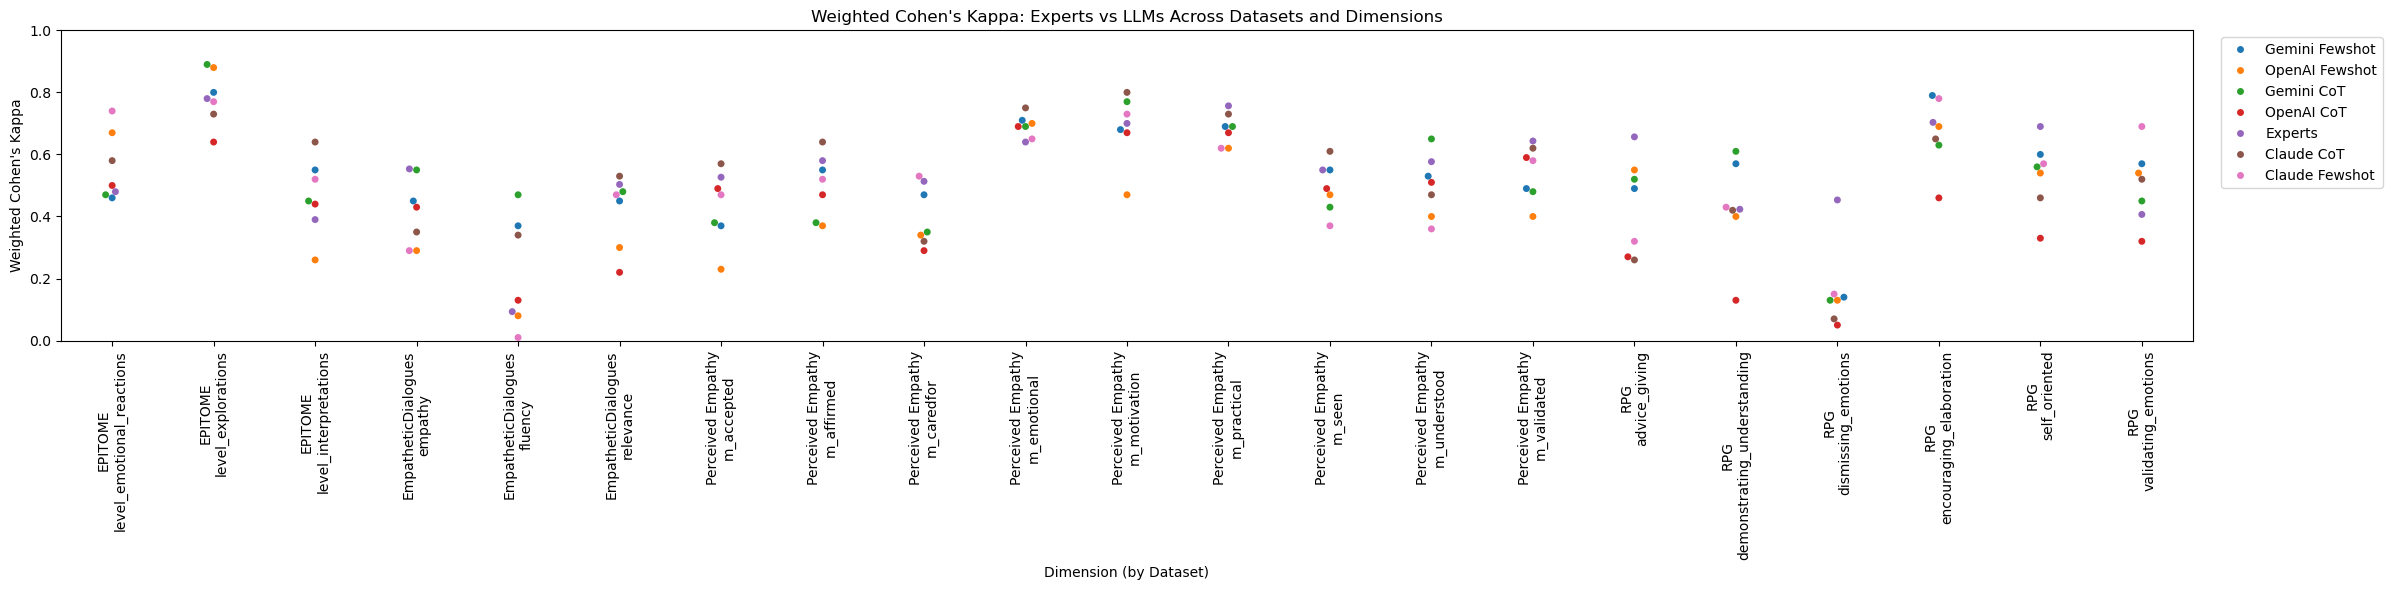

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute average of expert kappas
combined[('Experts', 'avg')] = combined[('Experts', '1 vs 2')].astype(float) \
    .add(combined[('Experts', '1 vs 3')], fill_value=0) \
    .add(combined[('Experts', '2 vs 3')], fill_value=0) / 3

# Step 2: Flatten the MultiIndex columns
combined_flat = combined.copy()
combined_flat.columns = ['_'.join(col).strip('_') for col in combined.columns]

# Step 3: Subset relevant columns
model_columns = [
    'Experts_avg',
    'OpenAI_Fewshot', 'OpenAI_CoT',
    'Gemini (2.5 pro)_Fewshot', 'Gemini (2.5 pro)_CoT',
    'Claude_Fewshot', 'Claude_CoT'
]
keep_cols = ['Dataset', 'Dimension'] + model_columns
df_plot = combined_flat[keep_cols]

# Step 4: Melt to long format
df_long = pd.melt(
    df_plot,
    id_vars=['Dataset', 'Dimension'],
    var_name='ModelPrompt',
    value_name='Kappa'
)

# Step 5: Clean labels
df_long['ModelPrompt'] = df_long['ModelPrompt'].replace({
    'Experts_avg': 'Experts',
    'OpenAI_Fewshot': 'OpenAI Fewshot',
    'OpenAI_CoT': 'OpenAI CoT',
    'Gemini (2.5 pro)_Fewshot': 'Gemini Fewshot',
    'Gemini (2.5 pro)_CoT': 'Gemini CoT',
    'Claude_Fewshot': 'Claude Fewshot',
    'Claude_CoT': 'Claude CoT'
})

# Step 6: Combine Dataset and Dimension into a single label
df_long['DimensionLabel'] = df_long['Dataset'] + '\n' + df_long['Dimension']

# Optional: sort by dataset or alphabetically
df_long = df_long.sort_values(by='DimensionLabel')

# Step 7: Plot all in one figure
plt.figure(figsize=(24, 6))  # Widen figure to fit many x-axis labels
sns.swarmplot(data=df_long, x='DimensionLabel', y='Kappa', hue='ModelPrompt')

# Final tweaks
plt.xticks(rotation=90)
plt.title("Weighted Cohen's Kappa: Experts vs LLMs Across Datasets and Dimensions")
plt.ylabel("Weighted Cohen's Kappa")
plt.xlabel("Dimension (by Dataset)")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

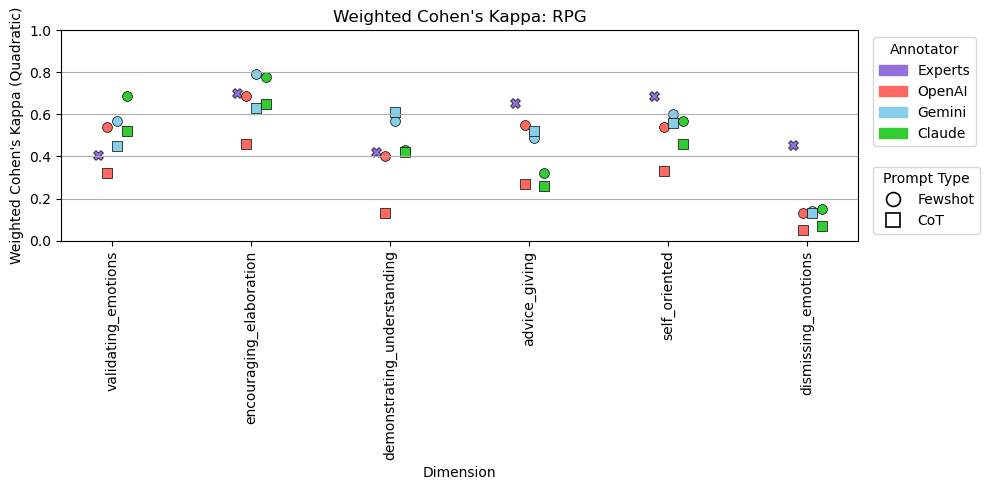

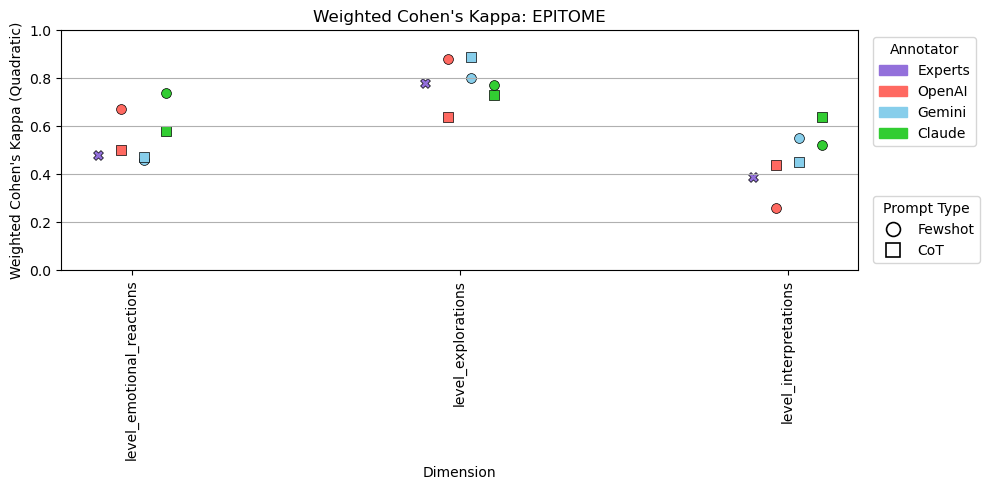

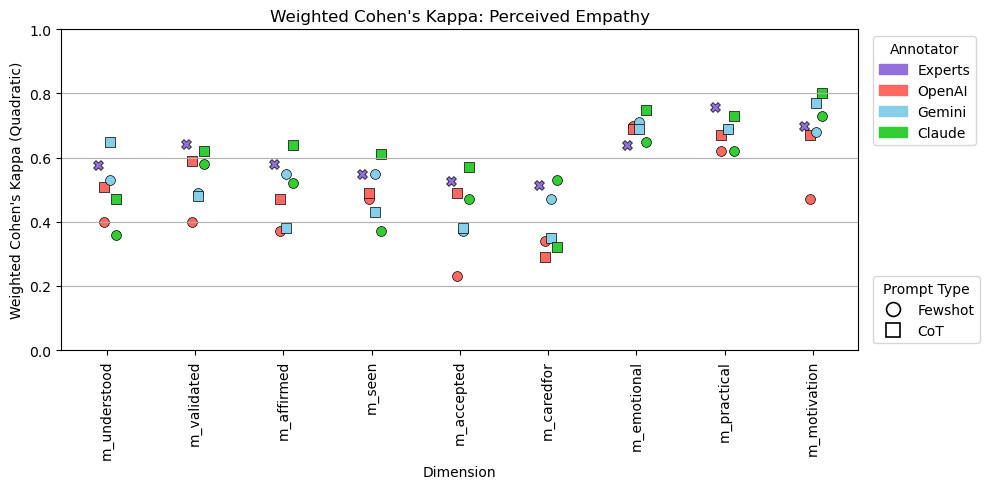

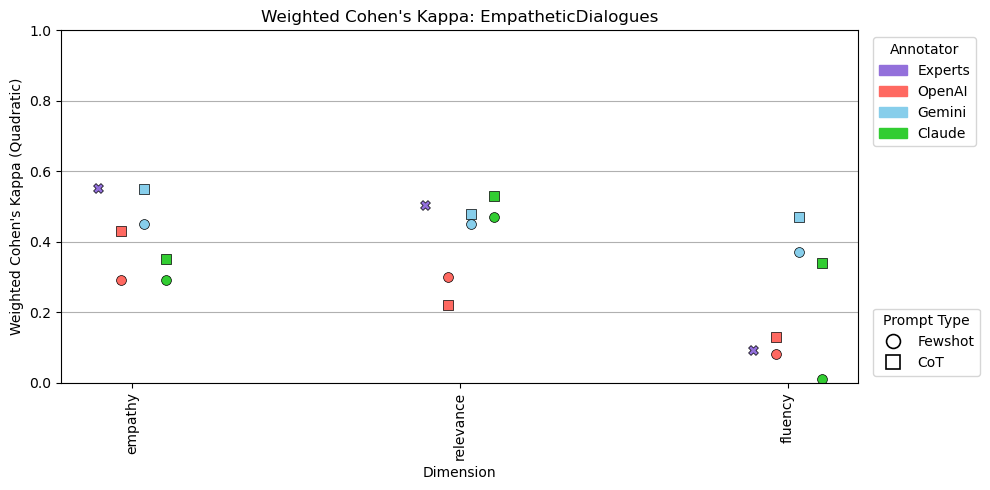

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# Step 1: Compute average of expert kappas
combined[('Experts', 'avg')] = combined[('Experts', '1 vs 2')].astype(float) \
    .add(combined[('Experts', '1 vs 3')], fill_value=0) \
    .add(combined[('Experts', '2 vs 3')], fill_value=0) / 3

# Step 2: Flatten MultiIndex columns
combined_flat = combined.copy()
combined_flat.columns = ['_'.join(col).strip('_') for col in combined.columns]

# Step 3: Select relevant columns
model_columns = [
    'Experts_avg',
    'OpenAI_Fewshot', 'OpenAI_CoT',
    'Gemini (2.5 pro)_Fewshot', 'Gemini (2.5 pro)_CoT',
    'Claude_Fewshot', 'Claude_CoT'
]
keep_cols = ['Dataset', 'Dimension'] + model_columns
df_plot = combined_flat[keep_cols]

# Step 4: Melt to long format
df_long = pd.melt(
    df_plot,
    id_vars=['Dataset', 'Dimension'],
    var_name='ModelPrompt',
    value_name='Kappa'
)

# Step 5: Annotator & Prompt type
df_long['Annotator'] = df_long['ModelPrompt'].apply(
    lambda x: 'Experts' if 'Experts' in x else
              'OpenAI' if 'OpenAI' in x else
              'Gemini' if 'Gemini' in x else 'Claude'
)
df_long['Prompt'] = df_long['ModelPrompt'].apply(
    lambda x: 'Fewshot' if 'Fewshot' in x else
              'CoT' if 'CoT' in x else 'N/A'
)

# Step 6: Style mappings
annotators = ['Experts', 'OpenAI', 'Gemini', 'Claude']
prompt_types = ['Fewshot', 'CoT']

color_map = {
    'Experts': '#9370DB',
    'OpenAI': '#FF6961',
    'Gemini': '#87CEEB',
    'Claude': '#32CD32'
}
marker_map = {
    'Fewshot': 'o',
    'CoT': 's'
}

# Step 7: Define horizontal offsets
n_annotators = len(annotators)
offset_vals = np.linspace(-(n_annotators - 1)/2, (n_annotators - 1)/2, n_annotators) * 0.07
offset_map = dict(zip(annotators, offset_vals))

# Step 8: Plot per dataset
datasets = df_long['Dataset'].unique()

for dataset in datasets:
    subset = df_long[df_long['Dataset'] == dataset].copy()
    dims = subset['Dimension'].unique()
    x_pos_map = {dim: i for i, dim in enumerate(dims)}

    plt.figure(figsize=(max(10, len(dims)*0.5), 5))

    for _, row in subset.iterrows():
        x_base = x_pos_map[row['Dimension']]
        x = x_base + offset_map[row['Annotator']]
        y = row['Kappa']
        plt.scatter(
            x,
            y,
            color=color_map[row['Annotator']],
            marker=marker_map.get(row['Prompt'], 'X'),
            s=50,
            edgecolor='black',
            linewidth=0.5
        )

    # X-axis labels
    plt.xticks(ticks=range(len(dims)), labels=dims, rotation=90)

    # Legends
    color_legend = [Patch(color=color_map[a], label=a) for a in annotators]
    shape_legend = [
        Line2D([0], [0], marker=marker_map[p], color='black', linestyle='',
               markerfacecolor='white', markersize=10, label=p, markeredgewidth=1.2)
        for p in prompt_types
    ]

    plt.title(f"Weighted Cohen's Kappa: {dataset}")
    plt.ylabel("Weighted Cohen's Kappa (Quadratic)")
    plt.xlabel("Dimension")
    plt.ylim(0, 1)
    plt.grid(axis='y')

    legend1 = plt.legend(handles=color_legend, title="Annotator", loc='upper left', bbox_to_anchor=(1.01, 1))
    legend2 = plt.legend(handles=shape_legend, title="Prompt Type", loc='lower left', bbox_to_anchor=(1.01, 0))
    plt.gca().add_artist(legend1)

    plt.tight_layout()
    plt.show()

['EmpatheticDialogues', 'EPITOME', 'Perceived Empathy', 'RPG']


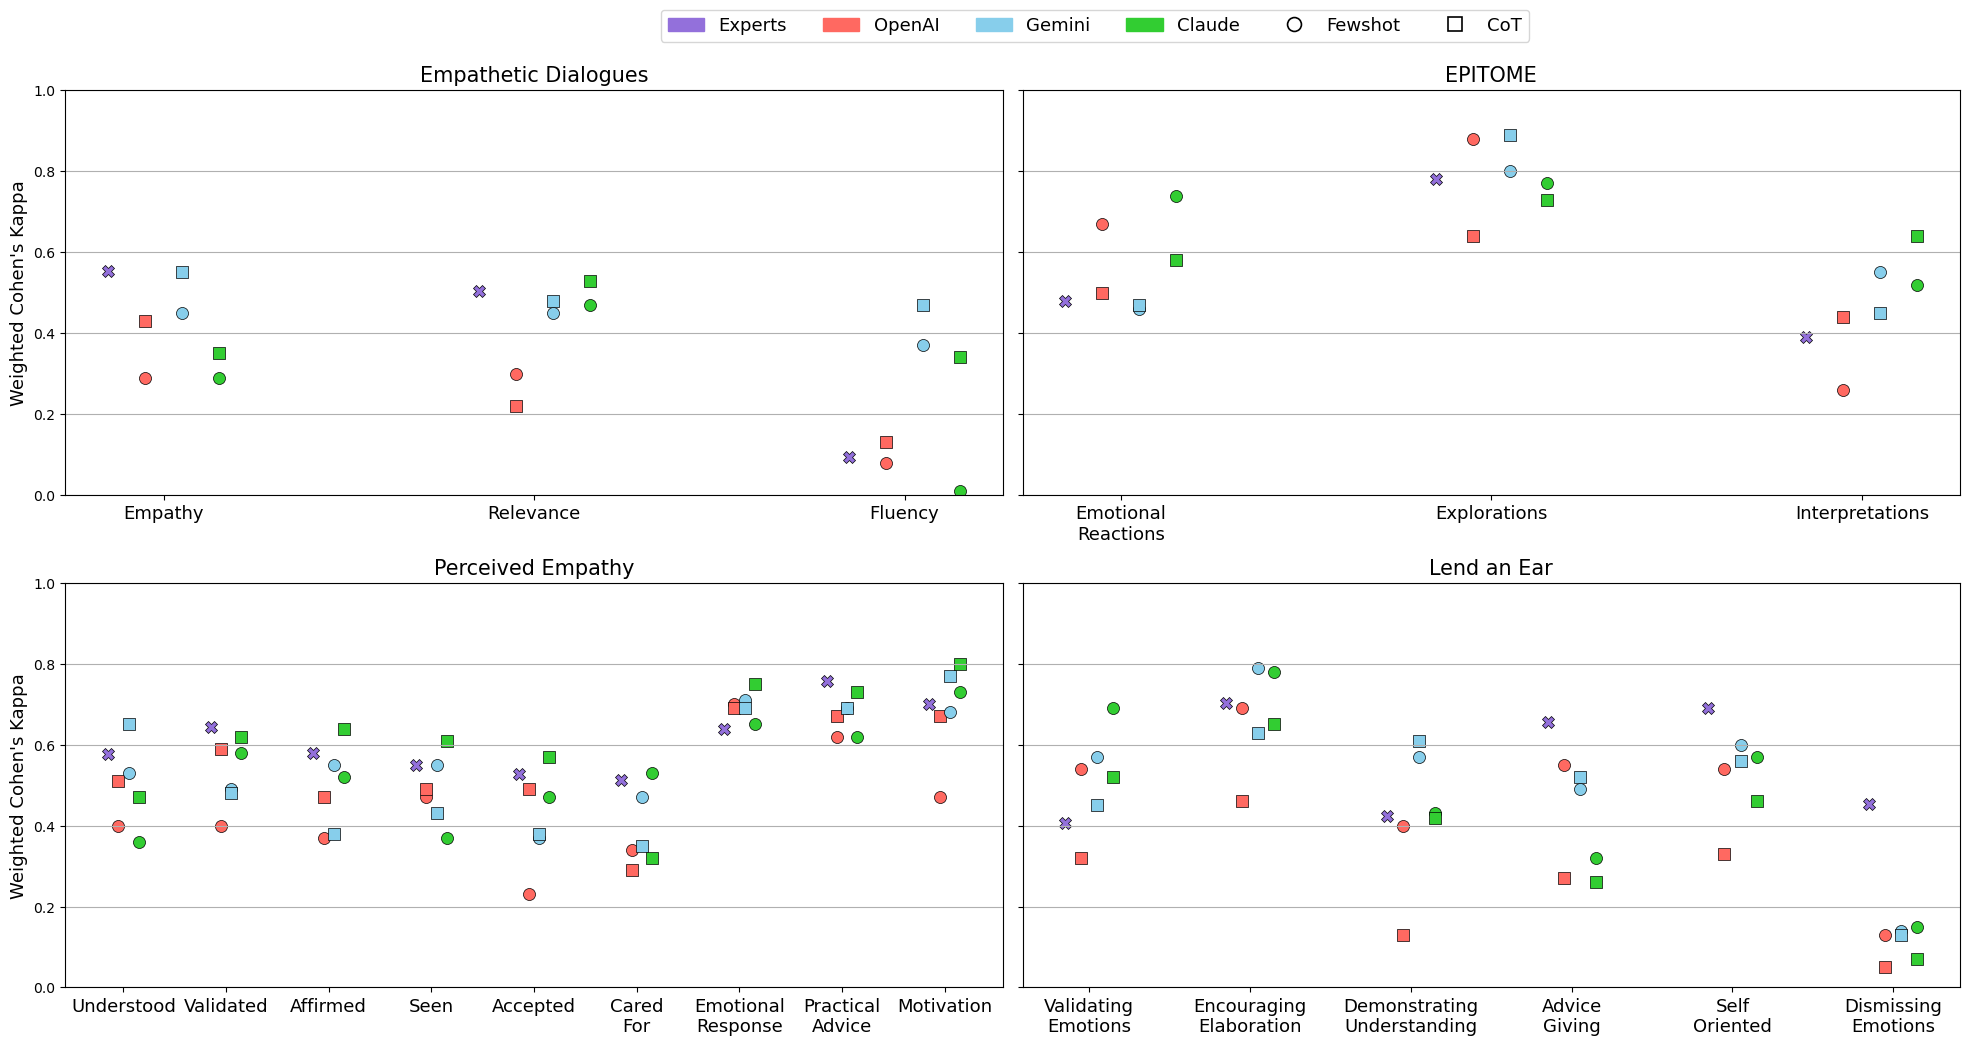

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# Step 1–6: same setup as before (flatten, melt, label annotators & prompts)
# [SKIPPING CODE FOR BREVITY — keep your setup for df_long, color_map, marker_map, etc.]

# Step 7: Define offset logic
annotators = ['Experts', 'OpenAI', 'Gemini', 'Claude']
prompt_types = ['Fewshot', 'CoT']

color_map = {
    'Experts': '#9370DB',
    'OpenAI': '#FF6961',
    'Gemini': '#87CEEB',
    'Claude': '#32CD32'
}
marker_map = {
    'Fewshot': 'o',
    'CoT': 's'
}
n_annotators = len(annotators)
offset_vals = np.linspace(-(n_annotators - 1)/2, (n_annotators - 1)/2, n_annotators) * 0.1
offset_map = dict(zip(annotators, offset_vals))

# Step 8: Create 2x2 subplot layout
datasets = ['EmpatheticDialogues', 'EPITOME', 'Perceived Empathy', 'RPG']
print(datasets)
fig, axes = plt.subplots(2, 2, figsize=(22, 10), sharey=True)
axes = axes.flatten()

for i, dataset in enumerate(datasets):
    ax = axes[i]
    subset = df_long[df_long['Dataset'] == dataset].copy()
    dims = subset['Dimension'].unique()
    x_pos_map = {dim: i for i, dim in enumerate(dims)}
    ax.set_xticks(range(len(dims)))  # Set exact positions for each dim

    for _, row in subset.iterrows():
        x_base = x_pos_map[row['Dimension']]
        x = x_base + offset_map[row['Annotator']]
        y = row['Kappa']
        ax.scatter(
            x,
            y,
            color=color_map[row['Annotator']],
            marker=marker_map.get(row['Prompt'], 'X'),
            s=75,
            edgecolor='black',
            linewidth=0.5
        )
    rename_map = {
    'validating_emotions': 'Validating\nEmotions',
    'encouraging_elaboration': 'Encouraging\nElaboration',
    'demonstrating_understanding': 'Demonstrating\nUnderstanding',
    'advice_giving': 'Advice\nGiving',
    'self_oriented': 'Self\nOriented',
    'dismissing_emotions': 'Dismissing\nEmotions',
    'level_explorations': 'Explorations',
    'level_emotional_reactions': 'Emotional\nReactions',
    'level_interpretations': 'Interpretations',
    'empathy': 'Empathy',
    'relevance': 'Relevance',
    'fluency': 'Fluency',
    'm_understood': 'Understood',
    'm_validated': 'Validated',
    'm_affirmed': 'Affirmed',
    'm_caredfor': 'Cared\nFor',
    'm_accepted': 'Accepted',
    'm_seen': 'Seen',
    'm_emotional': 'Emotional\nResponse',
    'm_practical': 'Practical\nAdvice',
    'm_motivation': 'Motivation'
    }
    custom_labels = [rename_map.get(dim, dim) for dim in dims]
    ax.set_xticklabels(custom_labels, rotation=0, ha='center')

    title_map = {
    'RPG': 'Lend an Ear',
    'EPITOME': 'EPITOME',
    'Perceived Empathy': 'Perceived Empathy',
    'EmpatheticDialogues': 'Empathetic Dialogues'
    }   
    ax.set_title(title_map.get(dataset, dataset), fontsize = 15)
    ax.set_xticks(range(len(dims)))
    ax.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=13)
    ax.set_ylim(0, 1)
    ax.grid(axis='y')
    if i % 2 == 0:
        ax.set_ylabel("Weighted Cohen's Kappa", fontsize = 13)

# Step 9: Shared legends
color_legend = [Patch(color=color_map[a], label=a) for a in annotators]
shape_legend = [
    Line2D([0], [0], marker=marker_map[p], color='black', linestyle='',
           markerfacecolor='white', markersize=10, label=p, markeredgewidth=1.2)
    for p in prompt_types
]

# Add legends to empty space
# fig.legend(handles=color_legend, title="Annotator", loc='upper left', bbox_to_anchor=(0.9, 0.95))
# fig.legend(handles=shape_legend, title="Prompt Type", loc='upper left', bbox_to_anchor=(0.9, 0.75))

# Combine both legends
all_handles = color_legend + shape_legend

# Create a single horizontal legend at the top center
fig.legend(handles=all_handles,
           loc='lower center',  # We'll position it precisely with bbox_to_anchor
           bbox_to_anchor=(0.5, 1.0),  # Slightly above the top (1.05)
           ncol=len(all_handles),  # All items in one row
           frameon=True,
           fontsize=13)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leaves 10% space at the top
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space on the right for legend
plt.show()

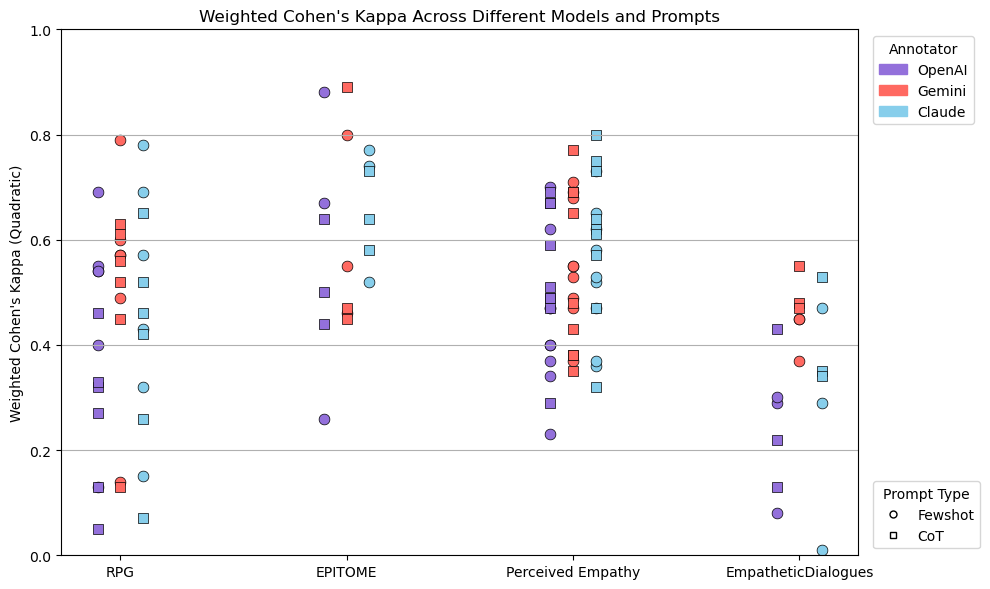

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# Step 1: Extract annotator and prompt type
df_long['Annotator'] = df_long['ModelPrompt'].apply(
    lambda model: 'OpenAI' if 'OpenAI' in model else
                  'Gemini' if 'Gemini' in model else
                  'Claude' if 'Claude' in model else 'Experts'
)
df_long['Prompt'] = df_long['ModelPrompt'].apply(
    lambda model: 'Fewshot' if 'Fewshot' in model else
                  'CoT' if 'CoT' in model else 'N/A'
)
df_filtered = df_long[df_long['Annotator'] != 'Experts']

# Step 2: Define colors and markers
annotators = ['OpenAI', 'Gemini', 'Claude']
n_annotators = len(annotators)
custom_colors = ['#9370DB', '#FF6961', '#87CEEB', '#32CD32']
color_map = dict(zip(annotators, custom_colors))
marker_map = {'Fewshot': 'o', 'CoT': 's'}

# Step 3: X positions by dataset only
datasets = df_long['Dataset'].unique()
x_positions = {dataset: i for i, dataset in enumerate(datasets)}

# Step 4: Offset based on annotator
width = 0.1
offset_values = np.linspace(-(n_annotators - 1) / 2.0, (n_annotators - 1) / 2.0, n_annotators) * width
offsets = dict(zip(annotators, offset_values))

# Step 5: Plot all points with offsets
plt.figure(figsize=(10, 6))

for _, row in df_filtered.iterrows():
    x = x_positions[row['Dataset']] + offsets[row['Annotator']]
    y = row['Kappa']
    plt.scatter(
        x,
        y,
        color=color_map[row['Annotator']],
        marker=marker_map.get(row['Prompt'], 'X'),
        s=60,
        edgecolor='black',
        linewidth=0.5
    )

# Step 6: Legends
color_legend = [Patch(color=color_map[a], label=a) for a in annotators]
shape_legend = [
    Line2D([0], [0], marker=marker_map[p], color='black', linestyle='',
           markerfacecolor='white', markersize=5, label=p, markeredgewidth=1)
    for p in ['Fewshot', 'CoT']
]

# Step 7: Final polish
plt.xticks(ticks=range(len(datasets)), labels=datasets)
plt.title("Weighted Cohen's Kappa Across Different Models and Prompts")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)")
plt.xlabel("")
plt.ylim(0, 1)
plt.grid(axis='y')

legend1 = plt.legend(handles=color_legend, title="Annotator", loc='upper left', bbox_to_anchor=(1.01, 1))
legend2 = plt.legend(handles=shape_legend, title="Prompt Type", loc='lower left', bbox_to_anchor=(1.01, 0))
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

In [10]:
expert2_rpg.loc[expert2_rpg['conversation_id'] == '20241031145619979111', :]

,conversation_id,validating_emotions,encouraging_elaboration,demonstrating_understanding,advice_giving,self_oriented,dismissing_emotions
40,20241031145619979111,3,3,4,1,1,1
